<h1 align="center">MSIN0143: Programming for Business Analytics</h1>
<h1 align="center">C2 Group Coursework</h1>
<h1 align="center">IMDb Tour</h1>
<h2 align="center">Classify and Predict Movie Ratings</h2>
<br><br><br>
<h3 align="center">Word Count: 2000 (including Appendix)</h3>
 <h3 align="center">December 2020</h3>

<h3>Table of Contents</h3>

* [1. Introduction](#1.-Introduction)
* [2. Data Preparation](#2.-Data-Preparation)
    * [2.1 Data Scraping](#2.1-Data-Scraping)
    * [2.2 Data Cleaning](#2.2-Data-Cleaning)
* [3. Data Analysis](#3.-Data-Analysis)
    * [3.1 Exploratory and Descriptive Analysis](#3.1-Exploratory-and-Descriptive-Analysis)
    * [3.2 Classification Tree Model](#3.2-Classification-Tree-Model)
* [4. Result Summary](#4.-Result-Summary)
* [5. Project Management](#5.-Project-Management)
* [6. Appendix](#6.-Appendix)
    * [6.1 Data Profile Table](#6.1-Data-Profile-Table)
    * [6.2 Side Analysis](#6.2-Side-Analysis)

## 1. Introduction

As a group of movie-goer, we enjoy debating on the best films during breakout session of MSIN0134.

We experimented with the heuristic approach to categorise the movies on IMDB based on rating distribution. Our heated debate on the best and worst movies in recent years are concluded as follows -

- **Best movies**: F-shaped distribution with most votes in top ratings. Lin-Manuel Miranda's Hamilton is GOLD.
- **Good movies**: P-shaped distribution with most votes among 7 to 10. Tenet is an absolute top-grossing movie amid COVID-19 twisting future and past.
- **Average movies**: D-shaped distribution with most votes among 4 to 7. Mulan is close to this category despite loads of votes in 1...
- **Bad movies**: L-shaped distribution being almost the opposite of the F-shape of best movies. Please, spare Jellicle Cats.

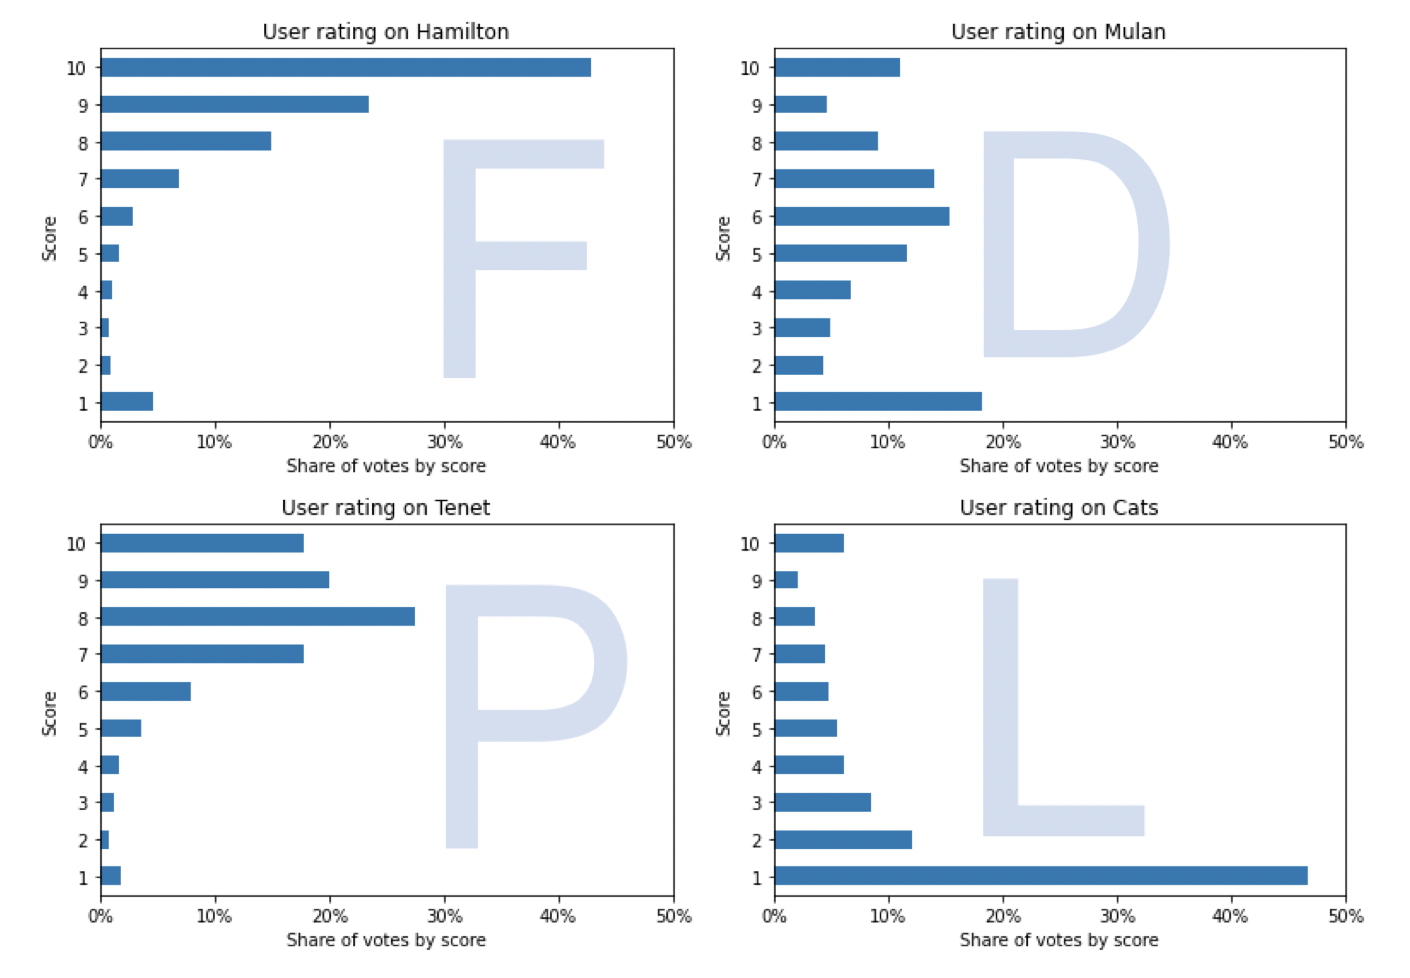

In [178]:
Image(filename = "ratingdistribution.png", width=750, height=300)

This debate triggered us to build a smarter approach to help the audience pick a good movie.

***How good is the movie*** is a complex topic involving production quality, storyline theme and reception from audience. As an exploration to identify ***movie quality*** , this report is aimed at approaching the classification of good movies on IMDB after exploring the movie patterns in recent years. The average rating will be used to verify our classification exercise.

The primary questions answered include -

- Supply side: What movies are produced in recent years?
- Demand side: How do the audience like (rate) these movies?
- Deep-dive into each attribute and explore the relationship with rating such as:
  * Any cyclic pattern in viewership by year? Favourite genre? Do professional audience prefer different movies?
- How to classify good movies and what attributes are useful (and feasible to us)?

In [1]:
# Display full output rather than just the last line of output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pydotplus
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import graphviz
from sklearn import tree
from IPython.display import Image
from sklearn.model_selection import train_test_split
from pandas import Series, DataFrame
import seaborn as sns
import csv
from operator import itemgetter
import networkx as nx
from networkx.algorithms import community
from bs4 import BeautifulSoup
import requests
import re
from IPython.display import Image
import plotly.figure_factory as ff
import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'pydotplus'

## 2. Data Preparation

- **Data Scraping**:
we focus on the most recent 50,000 movies on IMDB as of the date of scraping procedure (Nov 20, 2020), which covers movies from 2013 to Nov 2020.
- **Data Cleaning**:
validation on the scraped dataset and format transformation

## 2.1 Data Scraping

Note: The scraping script is presented with sample scraping scope only (5 rows) to avoid the activation of scraping process. The file with 50,000 movie data scraped from IMDB.com is stored as 'web_page_data.csv' for executing this notebook.

### 2.1.1 Scrape the url list of the most recent 50,000 movies

- Scraping source: the webpage link of each movie from the directory page of IMDB which is sorted by recency
- Scraping scope: ~1000 requests to get the url links of 50,000 movies.

In [3]:
# a quick check on IMDB's directory website shows the most recent 50,000 movies span from 2020 back to around 2010/2011
year_list = list(range(2010,2021))[::-1]

# create null dataframes to fill in with scraped data
total_scope = pd.DataFrame([])
temp_scope = pd.DataFrame([])

for j in year_list:
    
    # starting number of movie counter in the directory url link
    starting = 1
    
    while True:
        
        # set the url link for directory pages and request IMDB
        url = 'https://www.imdb.com/search/title/?title_type=feature&year=' + str(j) + '-01-01,' + str(j) 
        + '-12-31&view=simple&sort=num_votes,asc&start=' + str(starting)
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'lxml')
        
        # locate the main tags for content
        allentry = soup.find_all("div", {"class": "col-imdb-rating"})
        
        # parse the content in designated tags of each movie to a dictionary and stored in total_df
        for i in allentry:
            if i.text.strip() not in ['0','-']:
                # 4 attibutes (average rating, movie name, url link, and year of production) are useful to us
                temp = [{"avg_rt": i.text.strip(), \
                        "name": i.parent.find('a').text, \
                        "link":i.parent.find('a')['href'], \
                        "year": j}]
                temp_scope = pd.DataFrame.from_dict(list(temp))
                total_scope = pd.concat([total_scope, temp_scope], axis=0)
            else:
                continue
        
        # break this process if the movie has no votes, which returns 0 or - in the last designated tag
        if i.text.strip() in ['0','-']:
            break
        
        # threshold is set at 50,000 movies in practice, it is now limited to 5 movies to avoid network issue
        if len(total_scope) > 5:
            break
        
        # 50 records per directory page
        starting += 50
    
    # the following two lines are removed in practice as it is for demonstrating scraping process only
    if len(total_scope) > 5:
        break


# the lines below are in use in practice to confirm the scope of the recent 50,000 movies and store in local file
# total_scope = total_df.iloc[:50000]
# total_scope.to_csv('total_scope_trial.csv') 

total_scope.head(5)

TypeError: bad operand type for unary +: 'str'

### 2.1.2 Scrape the detailed content of 50,000 movies

- Scraping source: the individual movie page of 50,000 movies with details on rating, director, cast, etc.
- Scraping scope: 50,000 requests to IMDB
- Task distribution: to avoid suspicious detection from fibre company, the scraping task is distributed to each teammate to save time & mitigate the potential risk of network speed downgrade :D

In [4]:
# for report demonstration only: 
# currently using the url links scraped from last cell, please run the previous procedure to initialise this cell

# create the null dataframe and list to fill in with scraped data
total_df = pd.DataFrame([])
temp_df = pd.DataFrame([])
backup_list = []

# [:5] is removed in practice as it is for demonstrating scraping process only
for link in total_scope['link'][:5]:
    
    # temp variables
    director = []
    writer = []
    main_star = []
    cast = []
    
    # set the url link for individual movie pages and request IMDB
    url = 'https://www.imdb.com' + link
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'lxml')
    
    # set all variables with a default value 'None'
    name = "None"
    year = "None"
    length = "None"
    genre = "None"
    rls_date = "None"
    metascore = "None"
    rating_avg = "None"
    rating_count = "None"
    review_user_count = "None"
    review_critic_count = "None"
    country = "None"
    budget = "None"
    bo_openweekend_usa = "None"
    bo_gross_usa = "None"
    bo_ww = "None"
    
    # retrieve variables from soup by tag; using try/except to avoid distruption when the tag is missing
    try:
        name = soup.find('h1').text.split("(")[0]
    except:
        pass
    
    try:
        year = soup.find('h1').find("a").text
    except:
        pass
    
    try:
        length = soup.find("div", {"class": "subtext"}).find("time").text.strip()
    except:
        pass
    
    try:
        genre = [a.text.strip() for a in soup.find("div", {"class": "subtext"}).find_all("a")[:-1]]
    except:
        pass
    
    try:
        rls_date = soup.find("div", {"class": "subtext"}).find_all("a")[-1].text
    except:
        pass
    
    try:
        d = [a for a in soup.find_all('div',{'class':'credit_summary_item'})]
    except:
        pass
    
    try:
        for i in d[0].find_all("a"):
            if 'more credit' not in i.text:
                if 'cast & crew' not in i.text:
                    director.append(i.text.strip())
    except:
        pass
    
    try:
        for i in d[1].find_all("a"):
            if 'more credit' not in i.text:
                if 'cast & crew' not in i.text:
                    writer.append(i.text.strip())
    except:
        pass
    
    try:
        for i in d[2].find_all("a"):
            if 'more credit' not in i.text:
                if 'cast & crew' not in i.text:
                    main_star.append(i.text.strip())
    except:
        pass
    
    try:
        cast_list = soup.find('table',{'class':'cast_list'}).find_all("a")
        for i in cast_list:
            if i.text.strip() != '':
                cast.append(i.text.strip())
    except:
        pass
                
    try:
        metascore = soup.find('div',{'class':'metacriticScore score_favorable titleReviewBarSubItem'}).find("span").text
    except:
        pass
    
    try:
        rating_avg = soup.find('span',{'itemprop':'ratingValue'}).text
    except:
        pass
    
    try:
        rating_count = soup.find('span',{'itemprop':'ratingCount'}).text
    except:
        pass
    
    try:
        review_user_count = soup.find_all('span',{'itemprop':'reviewCount'})[0].text.split(" ")[0]
    except:
        pass
    
    try:
        review_critic_count = soup.find_all('span',{'itemprop':'reviewCount'})[1].text.split(" ")[0]
    except:
        details = soup.find_all('h4',{'class':'inline'})
        
    try: 
        for i in details:
            if i.text == "Country:":
                country = [each.text for each in i.parent.find_all("a")]
            elif i.text == "Budget:":
                budget = i.next_element.next_element.strip()
            elif i.text == "Opening Weekend USA:":
                if i.next_element.next_element.strip()[-1] == ',':
                    bo_openweekend_usa = i.next_element.next_element.strip()[:-1]
                else:
                    bo_openweekend_usa = i.next_element.next_element.strip()
            elif i.text == "Gross USA:":
                bo_gross_usa = i.next_element.next_element.strip()
            elif i.text == "Cumulative Worldwide Gross:":
                bo_ww = i.next_element.next_element.strip()
    except:
        pass
    
    # the useful attributes below are scraped and converted to a list
    # the scope of attributes is bigger than the actual analysis later as:
    # - we do not know the quality / number of missing value in each attribute
    # - we have not confirmed the exploratory analysis scope yet
    # - it is a tedious process to re-scrape 50,000 movies with another 50,000 requests
    
    temp = [{"name": name, \
             "year": year, \
             "length": length, \
             "genre": genre, \
             "rls_date": rls_date, \
             "director": director, \
             "writer": writer, \
             "main_star": main_star, \
             "cast": cast, \
             "metascore": metascore, \
             "rating_avg": rating_avg, \
             "rating_count": rating_count, \
             "review_user_count": review_user_count, \
             "review_critic_count": review_critic_count, \
             "country": country, \
             "budget": budget, \
             "bo_openweekend_usa": bo_openweekend_usa, \
             "bo_gross_usa": bo_gross_usa, \
             "bo_ww": bo_ww, \
             "link": link
             }]
    temp_df = pd.DataFrame.from_dict(list(temp))

    if name == "None":
        backup_list.append(link)
        backup = pd.DataFrame.from_dict(list(backup_list))

    #print(temp_df)
    total_df = pd.concat([total_df, temp_df], axis=0)
    
# the lines below are in use in practice to store the data to local directory
# total_df.to_csv('trial_' + str(len(total_df)) + '.csv')

total_df.head()

KeyError: 'link'

## 2.2 Data Cleaning

First, we look at the dataset as a whole and peform following steps:
-	Gain an understanding on the shape of the data and delete the not needed columns
-	Check for duplicates

Then, we investigate each variable individually and ensure they are ready for analysis with the following steps:
-	Investigate missing values for each variable and altering them according to their importance
-   Check if there are any outliers or values which do not belong in the respective column
-	Ensure variables are in suitable datatype

In [181]:
#import the dataset scraped from the previous procedure

file_name = "web_page_data.csv"

page_data = pd.read_csv(file_name)

In [182]:
# To start the cleaning process, we wan to get an overview of the shape of the dataset and its variables

page_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           50000 non-null  int64 
 1   name                 49993 non-null  object
 2   year                 50000 non-null  object
 3   length               50000 non-null  object
 4   genre                50000 non-null  object
 5   rls_date             50000 non-null  object
 6   director             50000 non-null  object
 7   writer               50000 non-null  object
 8   main_star            50000 non-null  object
 9   cast                 50000 non-null  object
 10  metascore            50000 non-null  object
 11  rating_avg           50000 non-null  object
 12  rating_count         50000 non-null  object
 13  review_user_count    50000 non-null  object
 14  review_critic_count  50000 non-null  object
 15  country              50000 non-null  object
 16  budg

In [183]:
# From the list of variables above, we can see that some are superfluous. The first being an additional column called Unnamed:0

del page_data["Unnamed: 0"]

# Furthermore, we can delete metascore as only 2,000 movies with a valid vlaue for this
print('Missing metascore: {} out of 50,000 records'.format(len(page_data[page_data["metascore"]=='None'])))
del page_data["metascore"]

# Moreover, only 300 rows have a box office usa value. Therefore, we can delete this column as well
print('Missing box office (Usa) value: {} out of 50,000 records'.format(len(page_data[page_data["bo_gross_usa"]=='None'])))
del page_data["bo_gross_usa"]


Missing metascore: 48088 out of 50,000 records
Missing box office (Usa) value: 49621 out of 50,000 records


In [184]:
# Next, we want to check if there are any duplicates in the dataset
# We can use the variable link here to check for duplicates as each film should have an individual link id.

print('Duplicated number of rows by link_id deleted: {} out of 50,000 records'.format(page_data["link"].duplicated().sum()))

page_data.drop_duplicates(subset ="link", keep = 'first', inplace = True) 

print('Total records after deleting duplicates: {}'.format(len(page_data)))

Duplicated number of rows by link_id deleted: 1 out of 50,000 records
Total records after deleting duplicates: 49999


In [185]:
# Next, we want to ensure every film has a valid name
# investigation results - the scraping process might have replaced the names from the valid rows by mistake
# recovery method - update the null names with the records from request dataframe as it is more complete
print('Record sample with missing film name: ')
page_data[page_data['name'].isnull()].head(1)

# Recovery method - update the null names with the records from request dataframe as it is more complete
total = pd.read_csv('total_scope.csv')
page_data=page_data.merge(total[['name','link']],on=['link'] ,how='left',suffixes=['','_scraped'])
page_data['name'] = np.where(page_data['name'].isnull(), page_data['name_scraped'], page_data['name'])
page_data = page_data.drop(['name_scraped'],axis=1)

Record sample with missing film name: 


name  year    length                genre                rls_date  \
3624  NaN  2019  1h 43min  ['Comedy', 'Drama']  25 October 2019 (UK)\n   

               director                                 writer  \
3624  ['Tadeusz Sliwa']  ['Filippo Bologna', 'Paolo Costella']   

                                              main_star  \
3624  ['Maja Ostaszewska', 'Lukasz Simlat', 'Aleksan...   

                                                   cast rating_avg  \
3624  ['Maja Ostaszewska', 'Anna', 'Lukasz Simlat', ...        6.8   

     rating_count review_user_count review_critic_count     country budget  \
3624          621                 2                None  ['Poland']   None   

     bo_openweekend_usa        bo_ww                link  
3624               None  $1,979,437   /title/tt10518924/

In [186]:
# Moving on, we clean the variable 'year'

page_data['year'].unique()

# Further investigation into rows with invalid values in year '2015839', '2964160', '2022581','937129'
# Result shows all columns are filled with invalid values, which might be due to scraping network issues
# Drop these rows as only 4 rows out of 49,999 records

tempyear = ['2015839', '2964160', '2022581','937129']
page_data[page_data['year'].isin(tempyear)].head(1)

print('Records with invalid value: {} out of 49,999 records'.format(len(page_data[page_data['year'].isin(tempyear)])))
page_data = page_data[~page_data['year'].isin(tempyear)]
print('Total records after deleting invalid scraped content: {}'.format(len(page_data)))

array(['2019', '2020', '2018', '2016', '2017', '2015', '2014', '2013',
       'None', '2021', '937129', '2015839', '2964160', '2022581'],
      dtype=object)

name    year  length   genre rls_date director  writer main_star  \
49995  937129  937129  937129  937129   937129   937129  937129    937129   

         cast rating_avg rating_count review_user_count review_critic_count  \
49995  937129     937129       937129            937129              937129   

      country  budget bo_openweekend_usa   bo_ww    link  
49995  937129  937129             937129  937129  937129

Records with invalid value: 4 out of 49,999 records
Total records after deleting invalid scraped content: 49995


In [187]:
# Next, we check the rows with 'None' in 'year' column
# Result: most of them have valid 'rls_date' (release date in top country)
page_data[page_data['year']=='None'].head(1)

# 'None' in 'year' column to be replaced with valid 'year' info in rls_date, so spliting 'year' data from 'rls_date'

# Define function to split rls_date
def trysplit(a):
    try:
        b = a.split('(')[0].strip().split(' ')
        c = b[len(b)-1]
        return c
    except:
        pass

#rls_year is supposed to return only yearly figures such as '2017'
page_data['rls_year']=page_data['rls_date'].apply(lambda x: trysplit(x))

name  year length        genre  \
25072  Sai Gon Trong Con Mua               None   None  ['Romance']   

                         rls_date           director  \
25072  2 October 2020 (Vietnam)\n  ['Le Minh Hoang']   

                                writer  \
25072  ['Le Minh Hoang', 'Do Hoa Tra']   

                                         main_star  \
25072  ['Truc Anh', 'Quang Dai', 'Phuong Anh Dao']   

                                                    cast rating_avg  \
25072  ['Truc Anh', 'Quang Dai', 'Phuong Anh Dao', 'N...        6.7   

      rating_count review_user_count review_critic_count      country budget  \
25072            6              None                None  ['Vietnam']   None   

      bo_openweekend_usa bo_ww                link  
25072               None  None  /title/tt12937684/

In [188]:
# Looking into rls_year, we see that is shows invalid values (all genre)

page_data['rls_year'].unique()
tempgenre = ['Thriller', 'Drama', 'Horror',
       'Family', 'Action', 'Comedy', 'Romance',
       'Sci-Fi', 'None', 'Mystery', 'History', 'Crime', 'Fantasy',
       'Animation', 'War', 'Music', 'Biography', 'Western',
       'Sport', 'Adventure', 'Musical', 'News']

array(['2019', '2020', 'Thriller', 'Drama', '2021', '2018', 'Horror',
       'Family', 'Action', '2016', '2017', '2015', 'Comedy', 'Romance',
       'Sci-Fi', 'None', 'Mystery', 'History', 'Crime', 'Fantasy',
       'Animation', 'War', 'Music', 'Biography', 'Western', '2013',
       '2014', 'Sport', 'Adventure', '2012', 'Musical', 'News'],
      dtype=object)

In [189]:
page_data[page_data['year']=='None'].shape

(12, 19)

In [190]:
# 982 rows with invalid genre info in 'rls_year' - compared with only 12 rows in 'year'
# Let's compare the quality of two columns by checking the 49003 rows with valid data from both columns
# Result: 7122 discrepencies between the two columns - need further investigation
page_data[page_data['rls_year'].isin(tempgenre)].shape
page_data[(~page_data['rls_year'].isin(tempgenre))&(page_data['year']!='None')].shape
df_year = page_data[(~page_data['rls_year'].isin(tempgenre))&(page_data['year']!='None')][['year','rls_year','link']]
df_year['check'] = np.where(df_year["rls_year"] == df_year["year"], True, False)
df_year['check'].value_counts()

# Result: rls year is mostly larger than year, and the manual checking on samples such as '/title/tt1988832/' show that
# Year shows a more accurate record as the theatrical release might be later than the publishment of media on movie festivals, online platform, etc.
# Decision: keep 'year' as the finalised year of release, and only update 'year' column with 'rls_year' when original 'year' is missing
df_year['compare'] = np.where(df_year["rls_year"] > df_year["year"], 'rls bigger', 'year bigger')
df_year['compare'] = np.where(df_year["rls_year"] == df_year["year"], 'equal', df_year['compare'])
df_year[df_year['check']==False]['compare'].value_counts()

# Finalise 'year' in main dataset and remove the 3 rows with invalid data; drop 'rls_date' and temp column 'rls_year'
page_data['year'] = np.where(page_data['year'] == 'None', page_data['rls_year'], page_data['year'])
page_data = page_data.drop(['rls_year','rls_date'],axis=1) 
page_data['year'].unique()
page_data.shape
print('Number of invalid data in year: ')
page_data[page_data['year'].isin(['Thriller', 'Romance'])].shape
page_data = page_data[~page_data['year'].isin(['Thriller', 'Romance'])]
page_data.shape

# Check the record with a future timestamp in 'year' 
page_data[page_data["year"] == "2021"]

# Further investigation into imdb website shows the film was released in 2017, so we change the year from 2021 to 2017
page_data.loc[page_data["year"] == "2021", 'year'] = '2017'

# Turn year value into a numeric value

page_data["year"] = page_data["year"].astype(int)

# Final check - 'year' variable all cleaned
page_data['year'].unique()

(982, 19)

(49003, 19)

True     41881
False     7122
Name: check, dtype: int64

rls bigger     7091
year bigger      31
Name: compare, dtype: int64

array(['2019', '2020', '2018', '2016', '2017', '2015', '2014', '2013',
       'Thriller', 'Romance', '2021'], dtype=object)

(49995, 17)

Number of invalid data in year: 


(2, 17)

(49993, 17)

name  year    length                  genre  \
39283  Construction   2021  1h 44min  ['Comedy', 'Romance']   

                  director            writer  \
39283  ['Malcolm Goodwin']  ['Victor Hawks']   

                                               main_star  \
39283  ['Victor Hawks', 'Gino Anthony Pesi', 'Devin R...   

                                                    cast rating_avg  \
39283  ['Victor Hawks', 'Gino Anthony Pesi', 'Devin R...        7.4   

      rating_count review_user_count review_critic_count  country     budget  \
39283           32              None                None  ['USA']  $150,000    

      bo_openweekend_usa bo_ww               link  
39283               None  None  /title/tt2133204/

array([2019, 2020, 2018, 2016, 2017, 2015, 2014, 2013])

In [191]:
# Next we will look into the genre variable. We start by checking genre for mising values

page_data[page_data["genre"] == "[]"].shape

# There are 1084 rows with unspecified genre. Will change the empty box to "unspecified"

page_data["genre"] = page_data["genre"].str.replace("\[]", "Unspecified")

(1084, 17)

In [192]:
# There are a maximum of three genres per movie. We wish to create three columns so that each has one genre for future analyses.
# We start by deleting the brackets in order to split genre data

page_data["genre"] = page_data["genre"].str.replace("[", "")
page_data["genre"] = page_data["genre"].str.replace("]", "")
page_data["genre"] = page_data["genre"].str.replace("\'", "")
page_data["genre"] = page_data["genre"].str.replace(" ", "")

# Split genre data into three separate columns
page_data[["genre1", "genre2", "genre3"]] = page_data.genre.str.split(",", expand =True)

# Final check on genre - None(null) if no multiple genres
page_data['genre1'].unique()
page_data['genre2'].unique()
page_data['genre3'].unique()

array(['Action', 'Drama', 'Family', 'Crime', 'Comedy', 'Mystery',
       'Romance', 'Adventure', 'Horror', 'Thriller', 'Fantasy',
       'Animation', 'Biography', 'Unspecified', 'Sport', 'Sci-Fi',
       'Musical', 'War', 'History', 'Music', 'Western', 'Documentary',
       'Reality-TV', 'News', 'Game-Show', 'Short'], dtype=object)

array([None, 'Drama', 'Sport', 'Fantasy', 'Crime', 'Horror', 'Family',
       'Thriller', 'Musical', 'Romance', 'Comedy', 'Mystery', 'Western',
       'Music', 'Action', 'War', 'Sci-Fi', 'History', 'Biography',
       'Adventure', 'Animation', 'News', 'Reality-TV'], dtype=object)

array([None, 'Sport', 'Drama', 'Family', 'Sci-Fi', 'Thriller', 'History',
       'Musical', 'Mystery', 'Romance', 'Horror', 'Fantasy', 'War',
       'Comedy', 'Crime', 'Music', 'Western', 'Adventure', 'Biography',
       'News', 'Action', 'Reality-TV'], dtype=object)

In [193]:
# For average ratings, we first change data type into a float
# Update the abnormal value 'None' with 0
# The 1 row with 'None' value does not have valid values in other attributes such as rating_count - to drop

page_data["rating_avg"] = page_data["rating_avg"].replace({"None":0}).astype(float)
page_data[page_data["rating_avg"]==0]
page_data.shape
page_data= page_data[page_data["rating_avg"]!=0]
page_data.shape

name  year length          genre                 director  \
26638  The Format   2020   None  Comedy,Horror  ['Vimalraj Jayaseelan']   

                        writer  \
26638  ['Vimalraj Jayaseelan']   

                                             main_star  \
26638  ['Molly Miller', 'Carrie Bernans', 'Logan Fry']   

                                                    cast  rating_avg  \
26638  ['Molly Miller', 'Carrie Bernans', 'Logan Fry'...         0.0   

      rating_count review_user_count review_critic_count  country budget  \
26638         None              None                None  ['USA']   None   

      bo_openweekend_usa bo_ww               link  genre1  genre2 genre3  
26638               None  None  /title/tt7584540/  Comedy  Horror   None

(49993, 20)

(49992, 20)

Share of movies with invalid length data:  8.79%


(0, 900)

(0, 9000)

Text(0.5, 1.0, 'Distribution of movies by year')

Text(0.5, 1.0, 'Distribution of movies by main genre')

Text(0.5, 1.0, 'Distribution of movies by average rating')

(49992, 20)

(45597, 20)

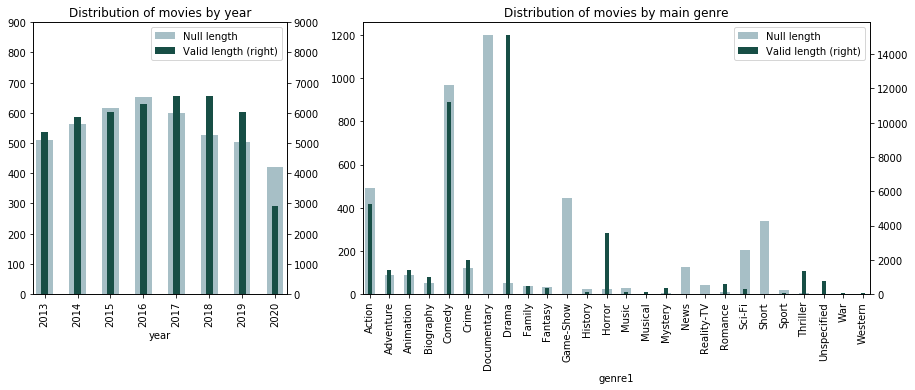

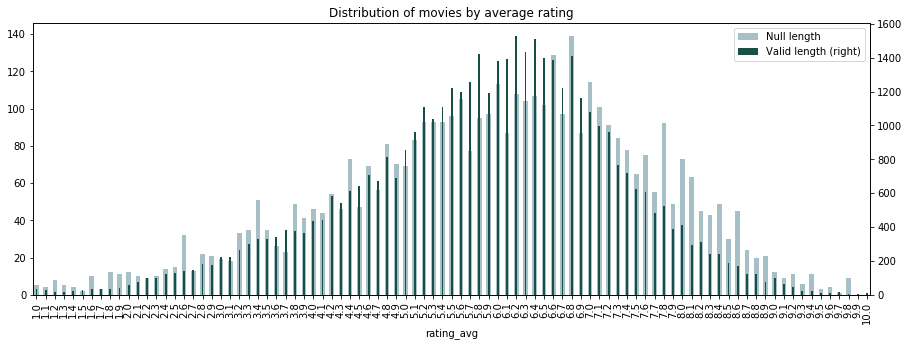

In [194]:
# Then we want to look at the variable length of movie

# Less than 9% of movies have invalid length data
print("Share of movies with invalid length data: ","{:.2%}".format(len(page_data[page_data["length"]=='None'])/len(page_data)))


# Check the distribution of these movies with null length by year, by main genre and by average rating
# lhs - movies with 'Null' length; rhs - movies with valid length
# Luckily not concentrated on any year or major genres  
# (1) to check Documentary - a very niche genre without much commercial impact in box office; so it is ignored for now
# Will decide if update length with mean by genre after further check

fig, (ax1, ax3) = plt.subplots(1, 2,figsize=(15,5),gridspec_kw={'width_ratios': [1, 2]})


ax1 = page_data[page_data["length"]=='None'][['year','length']].rename(columns={'length':'Null length'}).groupby('year').count().plot(kind='bar',ax=ax1,color='#a7bfc6',label='Null length')
ax2 = page_data[page_data["length"]!='None'][['year','length']].rename(columns={'length':'Valid length'}).groupby('year').count().plot(kind='bar',ax=ax1,color='#174e45',secondary_y=True,width=0.2,label='Valid length')
ax1.set_ylim([0, 900])
ax2.set_ylim([0, 9000])
ax1.set_title('Distribution of movies by year')

ax3 = page_data[page_data["length"]=='None'][['genre1','length']].rename(columns={'length':'Null length'}).groupby('genre1').count().plot(kind='bar',ax=ax3,color='#a7bfc6',label='Null length')
ax4 = page_data[page_data["length"]!='None'][['genre1','length']].rename(columns={'length':'Valid length'}).groupby('genre1').count().plot(kind='bar',ax=ax3,color='#174e45',secondary_y=True,width=0.2,label='Valid length')
ax3.set_title('Distribution of movies by main genre')

# Check the distribution of these movies with null length by average rating
# Result - the rows with null length is slightly right-skewed compared with null length
# Potential reason - the larger sample size in 'valid length' group provides a more normalised / rational rating
# These ratings are generally more centralised in the medium scores around 5 and 6

fig, ax5 = plt.subplots(nrows=1, ncols=1,figsize=(15,5))

ax5 = page_data[page_data["length"]=='None'][['length','rating_avg']].rename(columns={'length':'Null length'}).groupby('rating_avg').count().plot(kind='bar',ax=ax5,color='#a7bfc6',label='Null length')
ax6 = page_data[page_data["length"]!='None'][['length','rating_avg']].rename(columns={'length':'Valid length'}).groupby('rating_avg').count().plot(kind='bar',ax=ax5,color='#174e45',secondary_y=True,width=0.2,label='Valid length')
ax5.set_title('Distribution of movies by average rating')

# Conclusion - the records with missing length are not centralised in any spceific year, important genre or rating
# Therefore, the 8.79% records with null length are dropped in the dataset
page_data.shape
page_data = page_data[page_data["length"]!='None']
page_data.shape



In [195]:
# The length per film is given in hour and min format per film. In order to use the length for each film we need to turn it into numeric values.
# Ultimately we want one length column with the total minutes.
page_data['length'] = np.where(page_data['length']=='None', '0', page_data['length'])
#page_data['length'].unique()

In [196]:
# Split length of film data into hours and minutes
page_data[["hour", "min"]] = page_data["length"].str.split(expand = True)

In [197]:
# We can see that there are min values in the hour columns
page_data["hour"].unique()

# There are no hour values in the min column but are some with "None" values
page_data["min"].unique()

# We will fill the None values with 0
page_data[["hour", "min"]].fillna(0)

array(['1h', '2h', '45min', '52min', '3h', '167h', '57min', '58min',
       '48min', '50min', '56min', '46min', '54min', '6h', '2min', '5h',
       '4h', '51min', '55min', '49min', '47min', '59min', '53min', '1min',
       '15min', '42min', '8h', '20min', '11min', '6min', '44min', '12min',
       '40min', '30min', '18min', '13min', '41min', '9h', '39min', '21h',
       '19min', '10h', '33min', '18h', '5min', '13h'], dtype=object)

array(['28min', '13min', '45min', '33min', '46min', '23min', '12min',
       '30min', '40min', '24min', '25min', '29min', '15min', '19min',
       '21min', '7min', '58min', '20min', None, '39min', '51min', '32min',
       '22min', '47min', '49min', '50min', '14min', '35min', '38min',
       '31min', '27min', '37min', '34min', '18min', '44min', '26min',
       '48min', '1min', '16min', '8min', '3min', '43min', '53min',
       '54min', '59min', '57min', '11min', '10min', '42min', '36min',
       '4min', '5min', '41min', '55min', '6min', '2min', '17min', '56min',
       '52min', '9min'], dtype=object)

hour    min
0       1h  28min
1       1h  13min
2       1h  45min
3       1h  33min
4       1h  46min
...    ...    ...
49990   1h  46min
49991   1h  28min
49992   1h  51min
49993   2h  27min
49994   1h  45min

[45597 rows x 2 columns]

In [198]:
# Next, we find all the hour hour values and turn them into minute format. 
page_data["hour"] = page_data["hour"].str.replace("1h", "60min")
page_data["hour"] = page_data["hour"].str.replace("1h", "60min")
page_data["hour"] = page_data["hour"].str.replace("2h", "120min")
page_data["hour"] = page_data["hour"].str.replace("3h", "180min")
page_data["hour"] = page_data["hour"].str.replace("4h", "240min")
page_data["hour"] = page_data["hour"].str.replace("5h", "300min")
page_data["hour"] = page_data["hour"].str.replace("6h", "360min")
page_data["hour"] = page_data["hour"].str.replace("7h", "420min")
page_data["hour"] = page_data["hour"].str.replace("8h", "480min")
page_data["hour"] = page_data["hour"].str.replace("9h", "540min")
page_data["hour"] = page_data["hour"].str.replace("10h", "600min")
page_data["hour"] = page_data["hour"].str.replace("167h", "10020min")
page_data["hour"] = page_data["hour"].str.replace("13h", "780min")
page_data["hour"] = page_data["hour"].str.replace("18h", "1080min")
page_data["hour"] = page_data["hour"].str.replace("21h", "1260min")

In [199]:
# Create palceholder value for "none" so we can convert to integers
page_data["hour"] = page_data["hour"].str.replace("None", "0")

# Delete the str "min" so we can turn into integers
page_data["hour"] = page_data["hour"].str.replace("min", "")

# Turn hours column into integers

page_data["hour"] = page_data["hour"].astype(float)

# Now delete "min" from min column
page_data["min"] = page_data["min"].str.replace("min","")

# Fill na in min with 0s
page_data["min"] = page_data["min"].fillna(0)

# Turn min into integer
page_data["min"] = page_data["min"].astype(float)

# Create new column with length in min
page_data["length_min"] = page_data["hour"]+ page_data["min"]


In [200]:
#change 0 values to NaN
page_data["length_min"] = page_data['length_min'].replace(0.0, np.nan)

In [201]:
# Next, we can turn to the ratings

# There is one film in the dataset without any ratings, turn "None" into numerical 0

page_data["rating_count"] = page_data["rating_count"].replace("None", 0)

# Turn rating count into numerical data

page_data["rating_count"] = page_data["rating_count"].str.replace(",", "")

page_data["rating_count"] = page_data["rating_count"].astype(float)



In [202]:
# We can perform a similar process for the review user count
# There are 10054 rows with None as review_user_counts. We can assume None means 0 here, so we replace to numerical values

page_data["review_user_count"].value_counts()

page_data["review_user_count"] = page_data["review_user_count"].str.replace("None", "0")

page_data["review_user_count"] = page_data["review_user_count"].str.replace(",", "")

page_data["review_user_count"] = page_data["review_user_count"].astype(int)

page_data["review_user_count"] = page_data["review_user_count"].fillna(0)



None     10054
0         6849
1         6159
2         3516
3         2390
         ...  
889          1
565          1
1,591        1
1,205        1
525          1
Name: review_user_count, Length: 800, dtype: int64

In [203]:
# Next, we can check director variable

# There are only 93 rows without a director

# Manual investigation shows these records are mainly -
# (1) work-in-progress productions, such as "Friends 25th: The One with the Anniversary"
# (2) a collection of episodes, instead of an actual movie, such as "Bugs Bunny: Looney Tunes Cartoons 1942-1943"
# (3) a collage of media instead of an actual movie, such as "Matchbox Twenty Live North"

# Therefore, we will drop the records without valid director data

page_data[page_data["director"] == "[]"].shape
page_data[page_data["director"] == "[]"].head(5)
page_data = page_data[page_data["director"] != "[]"]

(93, 23)

name  year    length  \
282                      My Name Is Kim Bok Dong   2019  1h 47min   
1603                  Peppa Pig: Festival of Fun   2019   1h 8min   
2796  Friends 25th: The One with the Anniversary   2019  1h 45min   
6096                  Matchbox Twenty Live North   2015  1h 23min   
6131                                      Exeter   2015  1h 32min   

                 genre director writer main_star cast  rating_avg  \
282        Unspecified       []     []        []   []         4.2   
1603  Animation,Family       []     []        []   []         4.6   
2796            Comedy       []     []        []   []         3.1   
6096             Music       []     []        []   []         9.2   
6131       Unspecified       []     []        []   []         3.8   

      rating_count  ...  budget bo_openweekend_usa        bo_ww  \
282           27.0  ...    None               None    $559,065    
1603          88.0  ...    None               None         None   
2796         255.0  ...    None        $1,177,873   $3,403,406    
6096           5.0  ...    None               None         None   
6131           5.0  ...    None               None         None   

                    link       genre1  genre2 genre3  hour   min length_min  
282   /title/tt10809316/  Unspecified    None   None  60.0  47.0      107.0  
1603  /title/tt10112466/    Animation  Family   None  60.0   8.0       68.0  
2796  /title/tt10764458/       Comedy    None   None  60.0  45.0      105.0  
6096   /title/tt4473452/        Music    None   None  60.0  23.0       83.0  
6131   /title/tt4931374/  Unspecified    None   None  60.0  32.0       92.0  

[5 rows x 23 columns]

In [204]:
# Two columns 'main star' and 'cast' both reveal the movie cast , which can be supplemented to create a more complete list

# There are 3082 rows without a main star

page_data[page_data["main_star"] == "[]"].shape

# There are 450 without a cast

page_data[page_data["cast"] == "[]"].shape

# Check the differences between cast and main_star
page_data[(page_data["main_star"] != "[]") & (page_data["cast"] != "[]")][["main_star","cast"]].tail(5)

# Based on the investigation above, it can be seen that 'cast' covers -
# (1) more valid records than main_star
# (2) a more detailed list of actor/actress than main_star for each movie

# Therefore, 'cast' will be kept as for the network analysis
# The idea of replacing invalid 'cast' with 'main_star' is not feasible after realising the recordswith null cast
# Are all null in main_star as well. So we drop the rows with null value in cast

page_data[page_data["cast"] == "[]"]['main_star'].unique()
page_data.shape
page_data = page_data[page_data["cast"] != "[]"]
page_data.shape

(3082, 23)

(450, 23)

main_star  \
49990   ['Tak Sakaguchi', 'Yura Kondo', 'Takumi Saitoh']   
49991    ['Reza Attaran', 'Bri Fiocca', 'Mehdi Mehrabi']   
49992       ['Se-ha Ahn', 'Yo-Han Byun', 'Seo-jin Chae']   
49993    ['Neha Sharma', 'Aditya Seal', 'Aashim Gulati']   
49994  ['Frank Langella', 'Billy Crudup', 'Christina ...   

                                                    cast  
49990  ['Tak Sakaguchi', 'Yura Kondo', 'Takumi Saitoh...  
49991  ['Reza Attaran', 'Naser', 'Bri Fiocca', 'Mehdi...  
49992  ['Se-ha Ahn', 'Yo-Han Byun', 'Su-hyeon (young)...  
49993  ['Neha Sharma', 'Aditya Seal', 'Aashim Gulati'...  
49994  ['Frank Langella', 'Raymond', 'Billy Crudup', ...

array(['[]'], dtype=object)

(45504, 23)

(45054, 23)

In [205]:
# Next, we look at the review_critic_count variable

# The number of critic reviews on IMDB - it is an indicator of the popularity among professional audience
# Therefore, it is kept as it could be used as proxy on the importance of the movie by niche audience
# The titles without critic reviews are mostly small local production

page_data["review_critic_count"].value_counts()

# Replace none with 0 and make numerical

page_data["review_critic_count"] = page_data["review_critic_count"].str.replace("None", "0")

page_data["review_critic_count"] = page_data["review_critic_count"].str.replace(",", "")

page_data["review_critic_count"] = page_data["review_critic_count"].astype(int)

None    16043
1        5479
2        3299
3        2347
4        1950
        ...  
907         1
267         1
419         1
521         1
725         1
Name: review_critic_count, Length: 506, dtype: int64

In [206]:
# There are 406 rows without a country name

page_data[page_data["country"] == "None"].shape

# We check the distribution of movies without country, and it's randomised across important attributes
# including genre, year and rating_avg
# Safe to drop these records

# page_data[page_data["country"] == "None"].groupby('genre1').count()
# page_data[page_data["country"] == "None"].groupby('year').count()
# page_data[page_data["country"] == "None"].groupby('rating_avg').count()

page_data.shape
page_data = page_data[page_data["country"] != "None"]
page_data.shape

# Create a new column with the major country of production

# Delete brackets in order to split country data
page_data["country"] = page_data["country"].str.replace("[", "")
page_data["country"] = page_data["country"].str.replace("]", "")
page_data["country"] = page_data["country"].str.replace("\'", "")
page_data["country"] = page_data["country"].str.replace(" ", "")

page_data["country1"] = page_data.country.str.split(",", expand =True)[0]

(406, 23)

(45054, 23)

(44648, 23)

In [207]:
# Finally, we can look at box office worldwide. There are 31852 films without a bo ww value.

page_data[page_data["bo_ww"] == "None"].shape

# Turn bo_ww into numerical data by fisrt deleting $ sign and turning none into 0.0

page_data["bo_ww"] = page_data["bo_ww"].str.replace("None","0.0")
page_data["bo_ww"] = page_data["bo_ww"].str.replace("$","")
page_data["bo_ww"] = page_data["bo_ww"].str.replace(",","")


# Several films have non-usd values instead of $ value. Check exchange rate and change to $
page_data.loc[page_data["bo_ww"] == "INR149500000",'bo_ww'] = 2015839
page_data.loc[page_data["bo_ww"] == "INR122500000",'bo_ww'] = 1651775
page_data.loc[page_data["bo_ww"] == "INR69500000",'bo_ww'] = 937129
page_data.loc[page_data["bo_ww"] == "INR220000000",'bo_ww'] = 2966452
page_data.loc[page_data["bo_ww"] == "EUR2500000",'bo_ww'] = 2964160
page_data.loc[page_data["bo_ww"] == "INR150000000",'bo_ww'] = 2022581

# Change to numeic value
page_data["bo_ww"] = pd.to_numeric(page_data["bo_ww"])

# Change 0 values to NaN
page_data['bo_ww'] = page_data['bo_ww'].replace(0.0, np.nan)

(31852, 24)

In [208]:
page_data.to_csv('1213cleaned_updated.csv')

In [209]:
# Total valid records to be used for exploratory and prediction analysis
page_data.shape

(44648, 24)

After the cleaning process, we have managed to retain 44648 rows，euqating to 89% of the original data.

## 3. Data Analysis
### 3.1 Exploratory and Descriptive Analysis

This section focuses on studying the dataset attributes and on answering key questions related to the:
- **Supply side** : how many movies are produced yearly and does this number change over time? 
- **Demand side**: do users prefer certain genres over others? which are the most produced and rated types of movies? 
- **Popularity among general audience**: How is popularity among general audience? what is the variation of rating over years and by genres?
- **Popularity among professional audience**: what is the relationship between the popularity among professional audience, the genre, and the rating average of movies? 
- **Viewership behavoir**: what is the average duration of movie to keep audience focused and happy?

<Figure size 432x288 with 0 Axes>

Text(0, 0.5, 'count')

Text(0.5, 1.0, 'Number of movies produced by year')

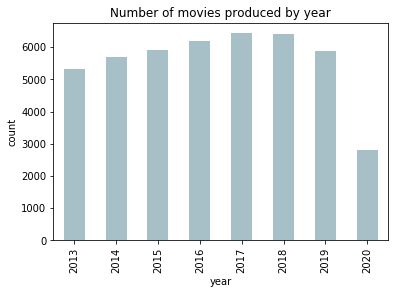

In [210]:
# Number of movies produced every year 
plt.figure(figsize=(6,4))
ax=page_data.groupby('year')['name'].count().plot(kind='bar',color = '#a7bfc6')
plt.ylabel('count')
plt.title('Number of movies produced by year')

**Overview: The movie industry is shrinking with negative growth after 2018; COVID-19 worsened the industry in 2020.**

Text(0.5, 1.0, 'Distribution of primary movie genre by year')

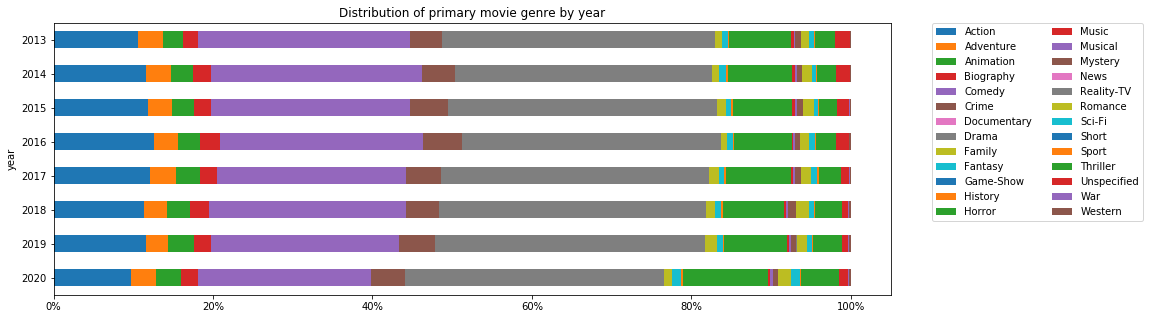

In [211]:
# the distribution of movies by genre and year
# supply side of movie industry - what movies are produced each year

fig, ax = plt.subplots(figsize=(15,5))
#temp_sort = page_data[page_data['year']==2020][['name','genre1']].groupby('genre1').count().sort_values(ascending=False)

ax = (page_data.groupby(['year','genre1'])['name'].count()/page_data.groupby(['year'])['name'].count()*100).unstack().plot.barh(stacked=True,ax=ax)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(100.0))
ax.set_title('Distribution of primary movie genre by year')
plt.gca().invert_yaxis()
plt.legend(loc="bottom right",ncol=2,borderaxespad=0.,bbox_to_anchor=(1.05, 1))

**Supply: Drama, Comedy, and Action are the most produced genres and the distribution of genres remain the same across the years.**

Text(0.5, 1.0, 'Rating Count by Genre')

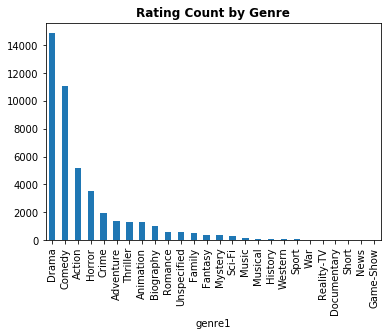

In [212]:
#demand side of movie industry - what movies are mostly watched (rated)
#create a graph which shows rating_count per genre
#proxy of popularity among the audience

rating_count_genre = page_data.groupby(['genre1'])['rating_count'].count()
ax_1 = rating_count_genre.sort_values(ascending=False).plot(kind='bar')
ax_1.set_title('Rating Count by Genre', fontweight="bold", size=12)

**Demand: Drama, comedy, and action are the most popular genres watched by audience. This complements with the previous observation and assures that there is minimal gap between supply and demand sides of movie industry.**

<Figure size 1152x288 with 0 Axes>

Text(0, 0.5, 'count')

Text(0.5, 1.0, 'Distribution of average rating')

Average rating of the most recent 50,000 movies on IMDB: 5.85 out of 10.


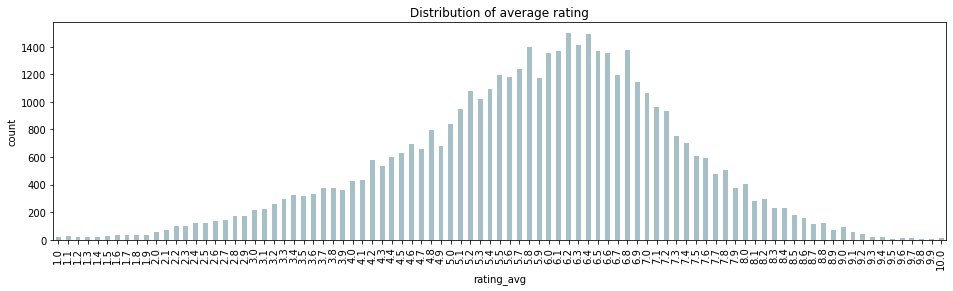

In [213]:
# distrubiton of average rating

plt.figure(figsize=(16,4))
ax=page_data.groupby('rating_avg')['name'].count().plot(kind='bar',color = '#a7bfc6')
plt.ylabel('count')
plt.title('Distribution of average rating')
print("Average rating of the most recent 50,000 movies on IMDB: {} out of 10.".format(round(page_data['rating_avg'].mean(),2)))
          

**Rating: The distribution of average rating is slightly right-skewed. The majority of movies have an average rating within the range of 5.5 and 6.5.**

In [214]:
#Discretize the rating_avg into buckets 
rating_avg = page_data['rating_avg']
labels = pd.cut(rating_avg, [0,2.5, 5, 7.5, 10])
labels
#group the data by genre and label to draw histogram:
grouped = page_data.groupby(['genre1', labels])
grouped.size().unstack(0)
#sum group amounts and normalize within buckets to visualize total genre movies within each bucket
bucket_sums = grouped.rating_avg.sum().unstack(0)
bucket_sums

normed_sums = bucket_sums.div(bucket_sums.sum(axis=1), axis=0)
normed_sums

0        (7.5, 10.0]
1         (5.0, 7.5]
2        (7.5, 10.0]
3        (7.5, 10.0]
4         (5.0, 7.5]
            ...     
49990     (5.0, 7.5]
49991     (2.5, 5.0]
49992     (5.0, 7.5]
49993     (2.5, 5.0]
49994     (5.0, 7.5]
Name: rating_avg, Length: 44648, dtype: category
Categories (4, interval[float64]): [(0.0, 2.5] < (2.5, 5.0] < (5.0, 7.5] < (7.5, 10.0]]

genre1       Action  Adventure  Animation  Biography  Comedy  Crime  \
rating_avg                                                            
(0.0, 2.5]      164         17         20          7     167     15   
(2.5, 5.0]     1594        306        261         61    2563    441   
(5.0, 7.5]     2985        893        851        790    7397   1326   
(7.5, 10.0]     429        140        137        131     961    182   

genre1       Documentary  Drama  Family  Fantasy  ...  News  Reality-TV  \
rating_avg                                        ...                     
(0.0, 2.5]             0    120       5       13  ...     0           0   
(2.5, 5.0]             0   2132     123      118  ...     0           1   
(5.0, 7.5]             2  10899     306      183  ...     1           1   
(7.5, 10.0]            0   1722      46       28  ...     0           2   

genre1       Romance  Sci-Fi  Short  Sport  Thriller  Unspecified  War  \
rating_avg                                                               
(0.0, 2.5]         9      21      0      1        15           12    0   
(2.5, 5.0]       100     124      0      5       506          100   15   
(5.0, 7.5]       411     133      1     26       710          358   12   
(7.5, 10.0]       64      24      0     20        69          113    6   

genre1       Western  
rating_avg            
(0.0, 2.5]         9  
(2.5, 5.0]        28  
(5.0, 7.5]        23  
(7.5, 10.0]        5  

[4 rows x 26 columns]

genre1        Action  Adventure  Animation  Biography   Comedy   Crime  \
rating_avg                                                               
(0.0, 2.5]     335.7       31.6       35.8       14.7    333.1    30.8   
(2.5, 5.0]    6527.8     1279.8     1100.8      261.0  10810.8  1866.7   
(5.0, 7.5]   18499.9     5573.9     5419.6     5145.2  45689.1  8240.0   
(7.5, 10.0]   3452.4     1136.8     1087.5     1067.2   7817.6  1476.6   

genre1       Documentary    Drama  Family  Fantasy  ...  News  Reality-TV  \
rating_avg                                          ...                     
(0.0, 2.5]           NaN    233.8    10.0     28.2  ...   NaN         NaN   
(2.5, 5.0]           NaN   9091.4   517.4    474.9  ...   NaN         3.7   
(5.0, 7.5]          13.1  68976.7  1867.8   1114.9  ...   5.6         5.9   
(7.5, 10.0]          NaN  13986.6   369.7    226.3  ...   NaN        16.0   

genre1       Romance  Sci-Fi  Short  Sport  Thriller  Unspecified   War  \
rating_avg                                                                
(0.0, 2.5]      18.0    46.0    NaN    2.0      31.2         25.8   NaN   
(2.5, 5.0]     426.0   475.8    NaN   21.0    2091.0        415.3  54.4   
(5.0, 7.5]    2568.0   820.5    6.4  158.8    4324.4       2263.9  77.6   
(7.5, 10.0]    519.6   197.2    NaN  166.1     547.6        923.9  50.1   

genre1       Western  
rating_avg            
(0.0, 2.5]      18.6  
(2.5, 5.0]     108.6  
(5.0, 7.5]     139.5  
(7.5, 10.0]     40.7  

[4 rows x 26 columns]

genre1         Action  Adventure  Animation  Biography    Comedy     Crime  \
rating_avg                                                                   
(0.0, 2.5]   0.196534   0.018500   0.020959   0.008606  0.195012  0.018032   
(2.5, 5.0]   0.148877   0.029188   0.025106   0.005953  0.246558  0.042573   
(5.0, 7.5]   0.102453   0.030868   0.030014   0.028494  0.253027  0.045633   
(7.5, 10.0]  0.098469   0.032424   0.031017   0.030438  0.222972  0.042115   

genre1       Documentary     Drama    Family   Fantasy  ...      News  \
rating_avg                                              ...             
(0.0, 2.5]           NaN  0.136877  0.005854  0.016510  ...       NaN   
(2.5, 5.0]           NaN  0.207345  0.011800  0.010831  ...       NaN   
(5.0, 7.5]      0.000073  0.381995  0.010344  0.006174  ...  0.000031   
(7.5, 10.0]          NaN  0.398923  0.010545  0.006454  ...       NaN   

genre1       Reality-TV   Romance    Sci-Fi     Short     Sport  Thriller  \
rating_avg                                                                  
(0.0, 2.5]          NaN  0.010538  0.026931       NaN  0.001171  0.018266   
(2.5, 5.0]     0.000084  0.009716  0.010851       NaN  0.000479  0.047689   
(5.0, 7.5]     0.000033  0.014222  0.004544  0.000035  0.000879  0.023949   
(7.5, 10.0]    0.000456  0.014820  0.005624       NaN  0.004737  0.015619   

genre1       Unspecified       War   Western  
rating_avg                                    
(0.0, 2.5]      0.015105       NaN  0.010889  
(2.5, 5.0]      0.009472  0.001241  0.002477  
(5.0, 7.5]      0.012538  0.000430  0.000773  
(7.5, 10.0]     0.026351  0.001429  0.001161  

[4 rows x 26 columns]

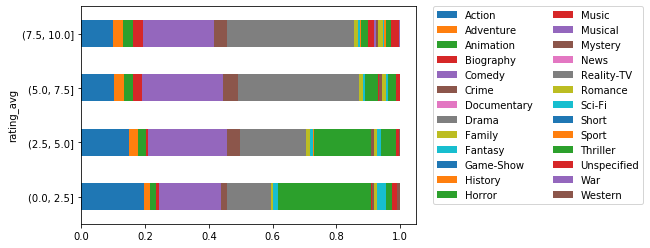

In [215]:
#plot the discretized ratings buckets and genres
plot = normed_sums.plot(kind='barh', stacked=True)
plot.legend(loc="bottom right",ncol=2,borderaxespad=0.,bbox_to_anchor=(1.05, 1))

**Deep-dive in rating: The rating of genres are different whereby Comedy and Drama are the top genres within the highest rating range. However, Action and Horror have the largest share in the lower range. This might be due to differences in the production and adverstising budgets of genres, and biased preferences of audience.**

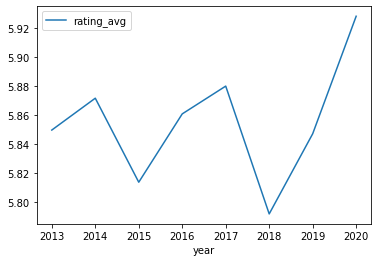

In [216]:
# average rating by year
page_data[['rating_avg','genre1','year']].groupby('year').mean().plot(kind='line')

**The variation of average rating follows a cyclic pattern with 2015 and 2018 lower than other years. This will be studied further within each genre.**

Text(0, 0.5, 'rating')

Text(0.5, 1.0, 'Distribution of average movie rating by year by genre')

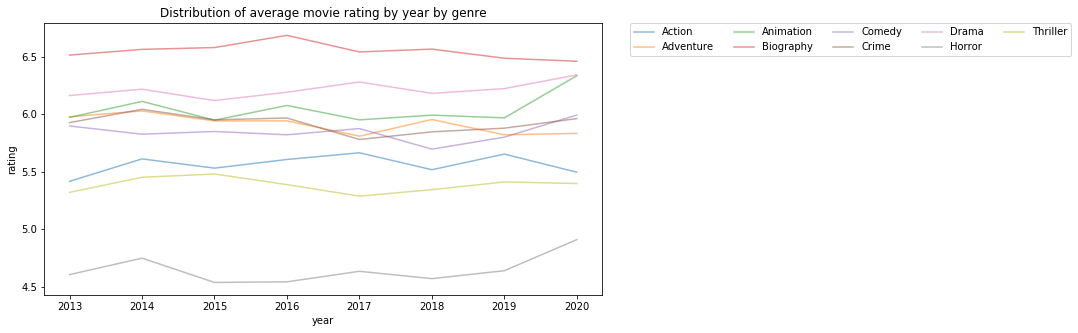

In [217]:
# distrubiton of average rating of top genre by year 
# only top 9 genres (avg rating) are here to keep analysis focused
top_genre = page_data[['rating_avg','genre1']].groupby('genre1').count().sort_values('rating_avg',ascending=False).reset_index()['genre1'][:9]
fig, ax = plt.subplots(figsize=(10,5))
ax=page_data[page_data['genre1'].isin(top_genre)].groupby(['year','genre1'])['rating_avg'].mean().unstack().plot(kind='line',alpha=0.5,ax=ax)
plt.ylabel('rating')
plt.title('Distribution of average movie rating by year by genre')
plt.legend(loc="bottom right",ncol=5,borderaxespad=0.,bbox_to_anchor=(1.05, 1))

**The cyclic pattern of rating also appears within each genre. This might be associated with changes in audience preferences as well as in cyclic production capacity and budget relative to each genre.**

Text(0, 0.5, 'count')

Text(0.5, 1.0, 'Distribution of average rating by primary genre')

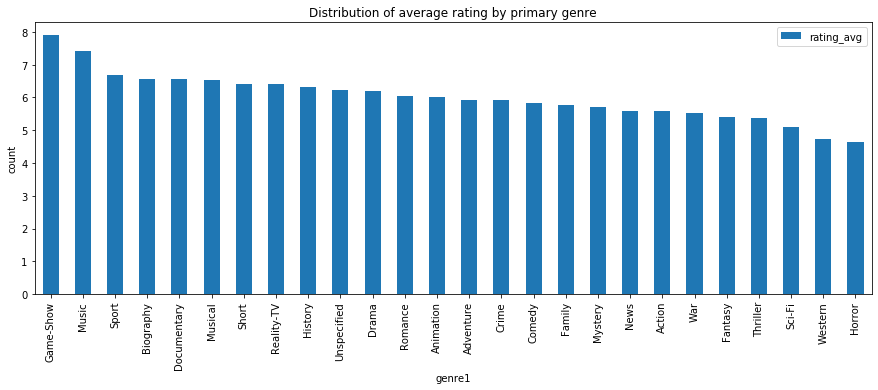

In [218]:
# distrubiton of average rating by genre

fig, ax = plt.subplots(figsize=(15,5))
ax=page_data[['rating_avg','genre1']].groupby(['genre1']).mean().sort_values(by='rating_avg',ascending=False).plot(kind='bar',ax=ax)
plt.ylabel('count')
plt.title('Distribution of average rating by primary genre')

**Game show and music have the highest average rating, potenially because (1) niche genres have a smaller sample size so results might be skewed (2) niche genres relate to sub-culture audience which is a dedicated supprting group who rate high on their favourates.**

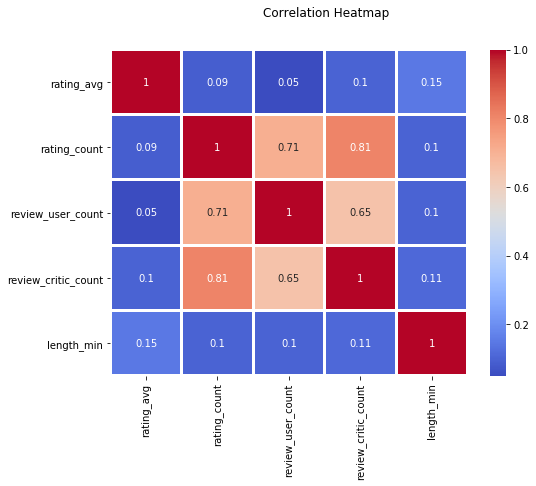

In [219]:
#create a correlation matrix for the variables of interest 
f, ax = plt.subplots(figsize=(8, 6))
hm = sns.heatmap(round(page_data[['rating_avg','rating_count','review_user_count', 'review_critic_count', 'length_min']].corr(),2), annot=True, ax=ax, linewidths=2, cmap="coolwarm")
t= f.suptitle('Correlation Heatmap', fontsize=12)

**Interestingly, average rating is correlated with number of critic review and movie length, but with low coefficients. Therefore, we will further study the relationship given the smaller correlation.** 

Text(0.5, 1.0, 'Relationship between the number of critic review and average rating')

Text(0.5, 0, 'Review_Critic_Count')

Text(0, 0.5, 'Rating_avg')

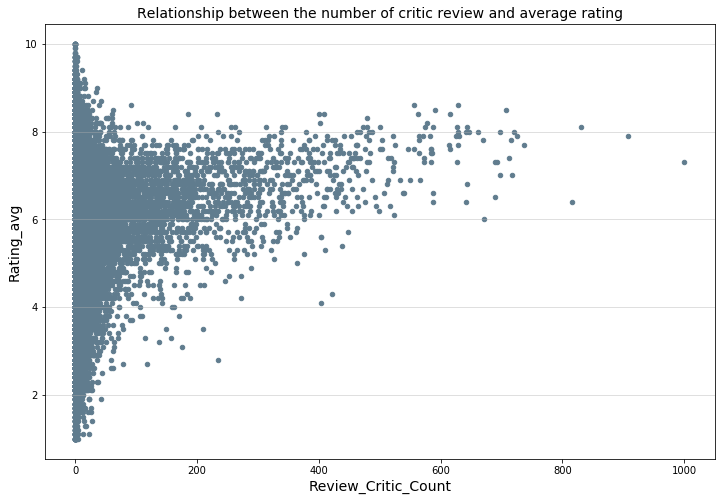

In [220]:
#Scatter plot for review critic count and rating avg 

page_data.plot.scatter(x="review_critic_count", y="rating_avg", figsize=(12,8), color='#607c8e')
plt.title('Relationship between the number of critic review and average rating', fontsize=14)
plt.xlabel('Review_Critic_Count', fontsize=14)
plt.ylabel('Rating_avg', fontsize=14)
plt.grid(axis='y', alpha=0.50)

**The relationship between critic_count and rating_avg reveals a threshold at around 200 critic reviews 
inwhich data after this point demonstrates that higher critic results in lower rating. This might be applicable among niche genres with a small dedicated audinece contributing to these reviews such as biography or documentary. However, the movies below 200 have a meduim magnitude effect of critic count on rating average whereby most movies have a rating avg between 5 and 7.**

Text(0, 0.5, 'review_critic_count')

Text(0.5, 1.0, 'Distribution of review critic count by primary genre')

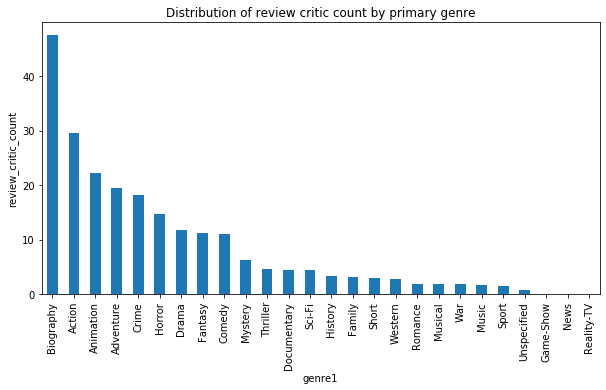

In [221]:
#group data by genres and average review critic count

fig, ax = plt.subplots(figsize=(10,5))
ax=page_data.groupby(['genre1']).mean()['review_critic_count'].sort_values(ascending = False).plot(kind='bar',ax=ax)
plt.ylabel('review_critic_count')
plt.title('Distribution of review critic count by primary genre')


**This graph confirms the interpretation above whereby biography and animation are among the highest in the critic counts potentially because they have dedicated fans. However, action movies are likely to be the movies with big budgets and brand awareness which eventually generate more critics.**

Text(0.5, 1.0, 'Relationship between Movie Duration and Rating Average')

Text(0.5, 0, 'length_min')

Text(0, 0.5, 'Rating_avg')

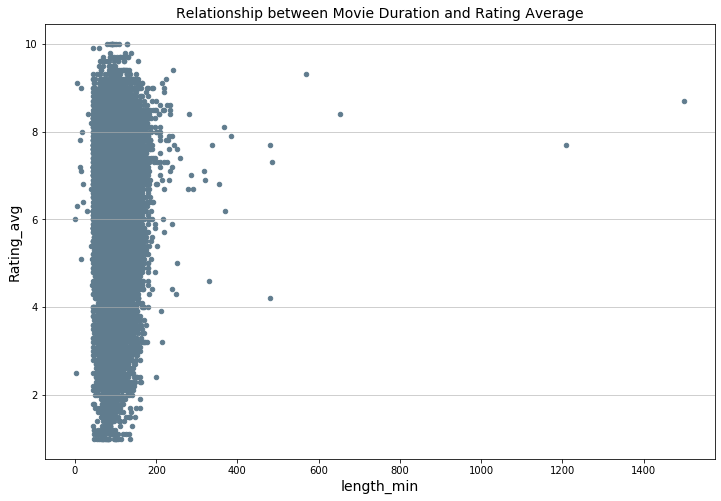

In [222]:
#Scatter plot for rating_average and length_min
page_data.plot.scatter(x="length_min", y="rating_avg", figsize=(12,8), color='#607c8e')
plt.title('Relationship between Movie Duration and Rating Average', fontsize=14)
plt.xlabel('length_min', fontsize=14)
plt.ylabel('Rating_avg', fontsize=14)
plt.grid(axis='y', alpha=0.75)

**There is no evident relationship between movie duration and rating average. Therefore, we will investigate the distribution of movie length by genre.**

Text(0, 0.5, 'length')

Text(0.5, 1.0, 'Distribution of average movie length by primary genre')

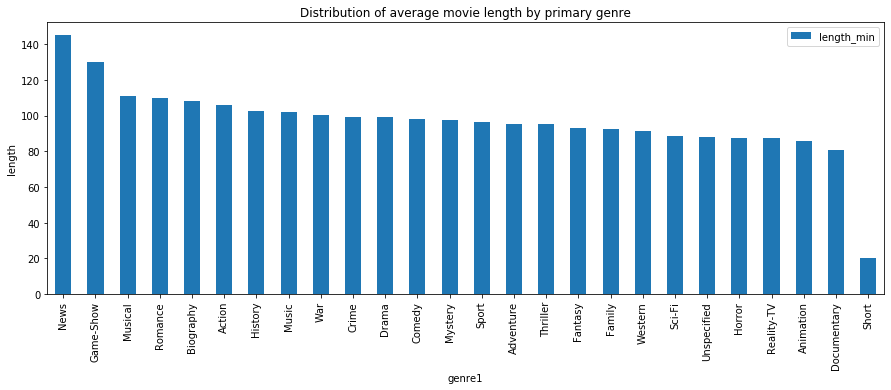

In [223]:
# distrubiton of average length by genre

fig, ax = plt.subplots(figsize=(15,5))
ax=page_data[['length_min','genre1']].groupby(['genre1']).mean().sort_values(by='length_min',ascending=False).plot(kind='bar',ax=ax)
plt.ylabel('length')
plt.title('Distribution of average movie length by primary genre')

**We infer that movie length is an inherent attribute by genre in which the length of most genres is around 100 minutes which is used to keep audience concentrated. However, niche topics with smaller sample size, such as 'News' and 'Game-Show', have longer length because of their focused audiance.**

### Unused important attributes related to production: "director", "cast", "writer" and "country"
**We reckon that these are important attributes in impacting the rating of the movie. Details in Result Summay**

### 3.2 Classification Tree Model

In this part, we built a classification tree model and used the attributes of the movies to predict how good they are.

**Phase 1: further data preparation for classification based on exploratory exercise above**

In [224]:
# Step 1 - attribute selection

# Based on exploratory analysis above -
# 6 attributes (year, average rating, total votes, votes of the critic review, genre, length) are selected

page_data=page_data[['year','rating_avg','rating_count','review_critic_count','genre1','length_min']]
page_data.head()

year  rating_avg  rating_count  review_critic_count  genre1  length_min
0  2019         9.2          21.0                    0  Action        88.0
1  2019         7.4          21.0                    0  Action        73.0
2  2019         9.0          21.0                    0   Drama       105.0
3  2019         8.6          21.0                    0  Family        93.0
4  2019         5.8          21.0                   23   Drama       106.0

In [225]:
# Step 2 - categorisation on average rating

# The movies are classified into 4 tiers based on the average rating
# '4' is the best movies ( 10 > rating >= 8) 
# '3' is the good movies ( 8 > rating >= 6) 
# '2' is average movies ( 6 > rating >= 4) 
# '1' is the worst movies ( rating < 4) 

def classify_rating(x):
    rating =''
    if x >= 8:
        rating = 4
    elif x < 8 and x >= 6:
        rating = 3
    elif x < 6 and x >= 4: 
        rating = 2
    else:
        rating = 1
    return rating

rating_dummy= page_data['rating_avg'].apply(classify_rating)
page_data['rating_dummy'] = rating_dummy
page_data['rating_dummy'].unique()

array([4, 3, 2, 1], dtype=int64)

In [226]:
# Step 3 - preliminary categorisation on genre

#  We rank genre based on the number of production from exploratory analysis above
# '0' is the genre with the lowest average rating
# '25' is the genre with the highest average rating

genreDict={'Game-Show':0, 'Short':1, 'Documentary':2, 'News':3 ,'Reality-TV':4, 'War':5 ,'Sport':6, 'Western':7, 'History':8, 'Musical':9, 
           'Music':10, 'Sci-Fi':11, 'Mystery':12, 'Fantasy':13, 'Family':14, 'Romance':15, 'Biography':16, 'unspecified':17, 'Adventure':18, 
           'Animation':19, 'Thriller':20, 'Crime':21, 'Horror':22, 'Action':23, 'Comedy':24, 'Drama':25}
page_data['genre2']=page_data['genre1'].map(genreDict)
page_data=page_data.dropna()
page_data['genre2']=pd.DataFrame(page_data['genre2'],dtype=np.int)
page_data=page_data[['year','rating_avg','rating_count','review_critic_count','genre2','length_min','rating_dummy']]
page_data.head()

year  rating_avg  rating_count  review_critic_count  genre2  length_min  \
0  2019         9.2          21.0                    0      23        88.0   
1  2019         7.4          21.0                    0      23        73.0   
2  2019         9.0          21.0                    0      25       105.0   
3  2019         8.6          21.0                    0      14        93.0   
4  2019         5.8          21.0                   23      25       106.0   

   rating_dummy  
0             4  
1             3  
2             4  
3             4  
4             2

In [227]:
# Step 4 - final categorisation on genre

# Based on the genre rank, we also classify genres into 4 tiers
# '4' is assigned to top 8 genres (rank over 18)
# '3' is assigned to genres that rank between 12-18
# '2' indicates the genres that rank between 5-12
# '1' indicates bottom 5 genres

def classify_genre(x):
    genre =''
    if x >= 18:
        genre = 4
    elif x < 18 and x >= 12:
        genre = 3
    elif x < 12 and x >= 5: 
        genre = 2
    else:
        genre = 1
    return genre

genre_dummy= page_data['genre2'].apply(classify_genre)
page_data['genre_dummy'] = genre_dummy
page_data['genre_dummy'].unique()

array([4, 3, 2, 1], dtype=int64)

In [228]:
#select the variables we want
page_data=page_data[['year','rating_count','review_critic_count','length_min','genre_dummy','rating_dummy']]

In [229]:
# Step 5

# transform rating data into catetgories

dummyColumns = ['rating_dummy','genre_dummy',]
for column in dummyColumns:
    page_data[column]= page_data[column].astype('category')

**Phase 2: Built classification tree**

The classification tree is built with the attributes and the rating tiers. Then we trained the model with the dataset.

In [230]:
#split training and test sets
train_set, test_set = train_test_split(page_data, test_size=0.2, random_state=42)

In [231]:
#choose featureData
fData = train_set[['year','rating_count','review_critic_count','length_min','genre_dummy']]

In [232]:
#set targetData
tData = train_set['rating_dummy'] 

In [233]:
#build classification tree
#set the max terminal nodes to 8
dtModel = DecisionTreeClassifier(max_leaf_nodes=8) 

In [234]:
#train the model
dtModel=dtModel.fit(fData,tData) 

We did visulisation on the tree to better demonstrate this exercise. According to the tree plot, we can see that the predictions only contain tier 2 and tier 3. Also, the gini indexes are not good since they are not close to 0.

In [235]:
#visulization
#we used Graphviz software to help generate the tree plot, if you has not installed it, 'GraphViz's executables not found' error will appear
dot_data = StringIO()

export_graphviz(
    dtModel,
    feature_names=['year','rating_count','review_critic_count','length_min','genre_dummy'],
    class_names=['1','2','3','4'],
    out_file=dot_data,
    filled=True,rounded=True,special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

In [236]:
#this step is to make the visulization tool can work
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

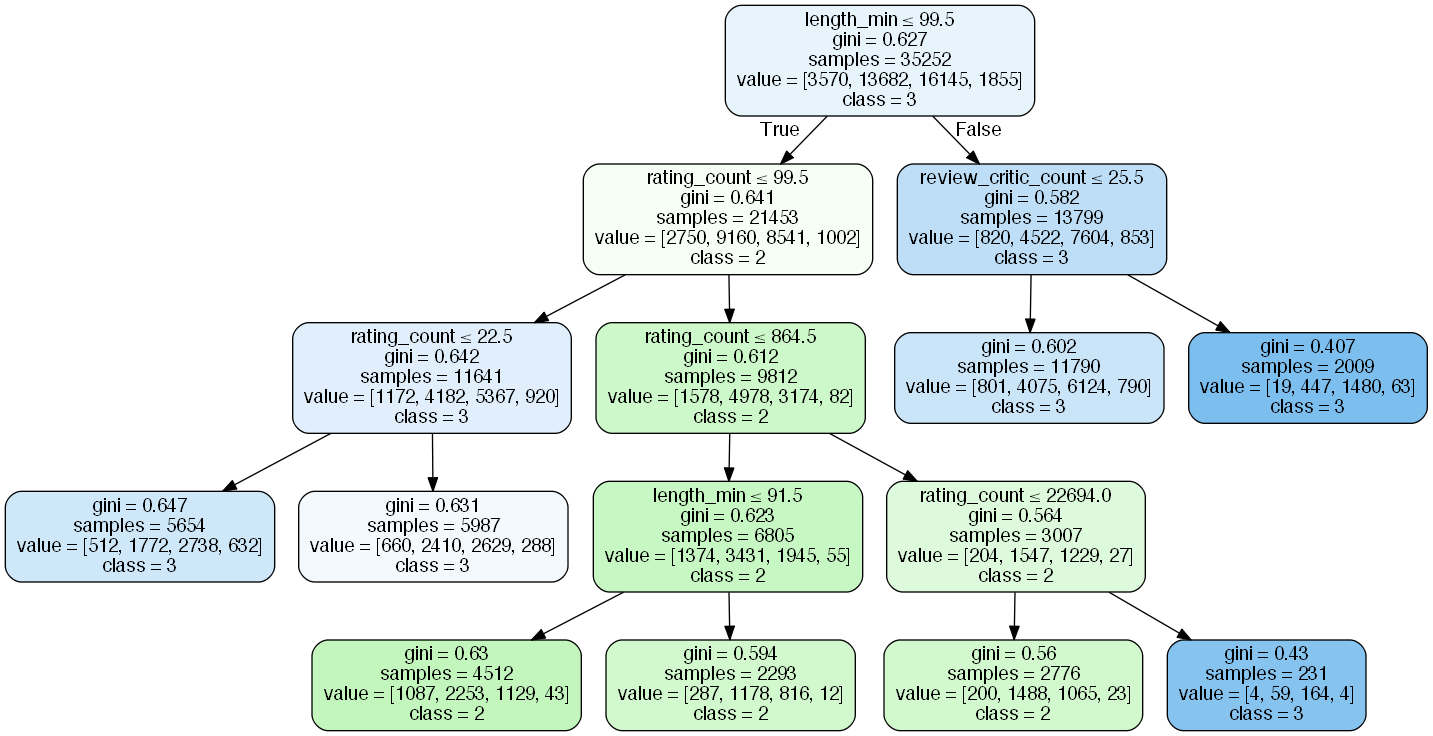

In [237]:
Image(graph.create_png())#prediction only contains 2 and 3，and gini are also not good since they are not close to 0

**Phase 3: Performance assessment on the tree**

Then we used both the training set and the test set to test the performance of classification tree. Hit rate is the criteria of performance. However, the hit rates of in both set are nearly 50%, which means we only predict half of the predictions correct.

In [238]:
#use the classification tree to predict
#If the prediction of rating tier is right, then hit = TRUE, 
#otherwise hit = FALSE. Hit rate is the proportion of the hit =TRUE. Hit rate being close to 1 means the performance is good.

train_set['ct_prediction']=dtModel.predict(train_set[['year','rating_count','review_critic_count','length_min','genre_dummy']])
test_set['ct_prediction']=dtModel.predict(test_set[['year','rating_count','review_critic_count','length_min','genre_dummy']])

In [239]:
#check the hit rate
train_set['ct_hit']=train_set['rating_dummy']==train_set['ct_prediction']
sum(train_set['ct_hit'])/len(train_set['ct_hit'])#51% predictions are right

test_set['ct_hit']=test_set['rating_dummy']==test_set['ct_prediction']
sum(test_set['ct_hit'])/len(test_set['ct_hit'])#52% predictions are right

0.5121411551117667

0.5204811074548962

The investigation on the detailed performance of hit rate in each rating tier reveals the predictions did not contain tier 1 and tier 4. This is mainly because these tiers represent the best movies and worst movies. In the original dataset, the majority of movies belong to tier 2 or tier 3. Therefore, the classification tree model cannot have enough observations of tier 1 and tier 4, thus leading to the unaccurate prediction in these two tiers. The area of improvements will be discussed in the next section.

In [240]:
#check the details of hit
#i.e. The results shows that for tier 2, the hit rate is 37%, and the hit rate of tier 3 is 82%

print('Hit rate of tier 1 rating in test_set is '+str(sum(test_set[page_data['rating_dummy']==1]['ct_hit'])/len(test_set[page_data['rating_dummy']==1])))
print('Hit rate of tier 2 rating in test_set is '+str(sum(test_set[page_data['rating_dummy']==2]['ct_hit'])/len(test_set[page_data['rating_dummy']==2])))
print('Hit rate of tier 3 rating in test_set is '+str(sum(test_set[page_data['rating_dummy']==3]['ct_hit'])/len(test_set[page_data['rating_dummy']==3])))
print('Hit rate of tier 4 rating in test_set is '+str(sum(test_set[page_data['rating_dummy']==4]['ct_hit'])/len(test_set[page_data['rating_dummy']==4])))

Hit rate of tier 1 rating in test_set is 0.0
Hit rate of tier 2 rating in test_set is 0.36619718309859156
Hit rate of tier 3 rating in test_set is 0.8201316110163295
Hit rate of tier 4 rating in test_set is 0.0


Then, we calculated the importance score of each attribute we used and create a plot to demonstrate it. According to the results, the total votes is the most important attribute for prediction, while the votes of the critic review is the least important one. In addition, we found that year and genre are not used for prediction in the model. Maybe in every year and all kinds of genre, there are good movies and bad movies. They are not important attributes to judge the popularity of a movie.

In [241]:
#see the importance of the attributes
names = ['year','total votes','votes of the critic review','length','genre']
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), dtModel.feature_importances_), names), reverse=True))

Features sorted by their score:
[(0.4669, 'total votes'), (0.4036, 'length'), (0.1296, 'votes of the critic review'), (0.0, 'year'), (0.0, 'genre')]


Text(0.5, 1.0, 'Feature Importances')

<BarContainer object of 5 artists>

([<matplotlib.axis.YTick at 0x1f05d450d08>,
 <a list of 5 Text yticklabel objects>)

Text(0.5, 0, 'Relative Importance')

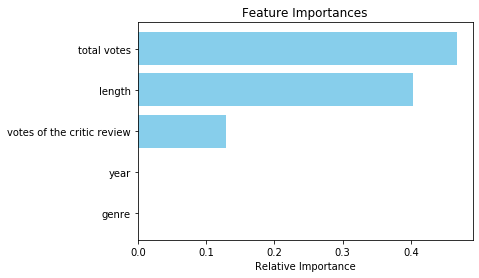

In [242]:
#visulise the importance
features =['year','rating_count','review_critic_count','length_min','genre_dummy']
importances = dtModel.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='skyblue', align='center')
y=['total votes','length','votes of the critic review','year','genre']
y_pos = [4,3,2,1,0]
plt.yticks(y_pos, y)
plt.xlabel('Relative Importance')
plt.show()

## 4. Result Summary

Referring back to the initial heuristic classification of  F, P, D and L-shaped distribution on Best, Good, Average and Bad movies, our classification tree approached managed to automate the classification process of good movies with higher average ratings. Following the exploratory analysis, we explored the key trends in supply and demand side of movie industry with a focus on its magnitude to movie rating, which directed us to locate the attributes that are important to the classification – despite a currently 50% hit rate.
This report is finished, but the exploration for movie-goers never stop. We have identified the areas for improvement after reflecting our analysis and the key topics to improve include –
-	**Data Collection**: reshape the scope of dataset to the recent 50,00 movies with **at least 50 votes and valid financial data on box office / budget** as (1) the current dataset has a long-tail of niche movies that create noise for our analysis, (2) the exploratory analysis could be more robust assessing financial success against movie quality
-	**Data Cleaning**: build data pipeline and functions to automate the cleaning process
-	**Exploratory analysis**: the production details such as director, actor, writer and origin country are not included in this report due to team capacity. However, these are all important attributes with magnitude on movie quality and rating. Appendix 6.2 displays a trial network analysis on production team as we plan to explore these attributes in winter break.
-	**Classification exercise**: we could try to collect more data in each tier to make sure that the model can be trained with enough data. Also, we could build advanced models like random forest and improve the performance by using attributes like director and actor 

## 5. Project Management

In [5]:
#The project is divided into six phases:

#Phase 1 : Pre-task brainstorming and finalising a topic
#Phase 2 : Initiating the web page scaping tasks; each one working on 10,000 movies.
#Phase 3 : Webpage data wrangling
#Phase 4 : Making meaningful data visualization and statistical reporting
#Phase 5 : Building the models that will be used to classify movies into different tiers.
#Phase 6 : Writing up the report.

import plotly.figure_factory as ff
df = [dict(Task="Phase 1: Ideation", Start='2020-11-02', Finish='2020-11-09', Resource='Ideation'),
      dict(Task ="Phase 2: Data Scrapping", Start='2020-11-09', Finish='2020-11-16', Resource='Data Scrapping' ),
      dict(Task ="Phase 3: Data Cleaning", Start='2020-11-16', Finish='2020-11-23', Resource='Data Cleaning'),
      dict(Task ="Phase 4: Exploratory Analysis", Start='2020-11-23', Finish='2020-12-07', Resource='Exploratory Analysis'),
      dict(Task ="Phase 5: Predictive Models", Start='2020-11-30', Finish='2020-12-07', Resource='Predictive Models' ),
      dict(Task ="Phase 6: Report", Start='2020-12-01', Finish='2020-12-14', Resource='Report')][::-1]

colors = {'Ideation': 'rgb(220, 0, 0)',
          'Data Scrapping': (1, 0.9, 0.16),
          'Data Cleaning': 'rgb(0, 250, 100)',
          'Exploratory Analysis': 'rgb(225, 0, 0)',
          'Predictive Models': (1, 0.8, 0.16),
          'Report': 'rgb(0, 250, 100)'}

fig = ff.create_gantt(df, colors=colors, index_col='Resource', show_colorbar=True,
                      group_tasks=True, width = 2000, height = 800)

fig = ff.create_gantt(df)
fig.layout.xaxis.tickvals = ('2020-11-02', '2020-11-09' , '2020-11-16',  '2020-11-23', '2020-11-30', '2020-12-07')    
fig.show()


## 6. Appendix

### 6.1 Data Profile Table

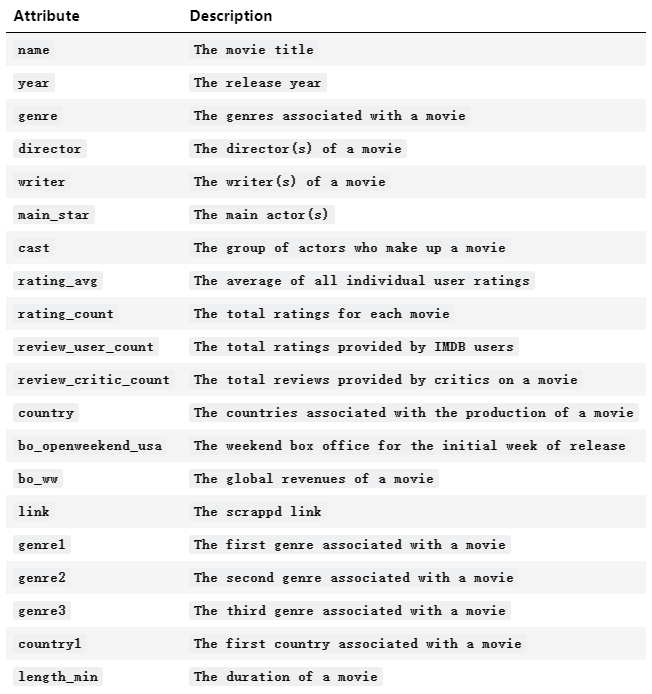

In [244]:
Image(filename = "profile.png", width=600, height=200)

### 6.2 Side Analysis - network analysis

- **Hypothesis**: movies and actor/actress with higher centrality in film industry are likely to be impactful movies and influential actors. i.e. Avengers has gathered an impressive group of cast and the rating is 8 out 10.
- **Goal**: to identify the movies with higher centrality in the cast network and weight the edge by movie rating.
- **Approach**: movies and corresponding casts are set as nodes, with genre and average ratings as edges to form  connections.
- **Progress**: we did a trial on American movies produced in 2019 to grasp the idea of network analysis, but it amplies the long-tail collection problem of our dataset - the dataset is skewed to small movies and productions so out result is scattered. It is abandoned in the classification exercise.
- **Future improvement**: to expand the scraping scope of the movies and update the dataset to 50,000 movies with significant user votes (i.e. > 500) to perform network analysis.

In [14]:
file_name = "1213cleaned_updated.csv"

page_data = pd.read_csv(file_name)

In [15]:
# We firstly narrow the scope down to only movies produced in USA in 2019 to grasp a more tightly-connected network.
page_data=page_data[page_data["country1"] == "USA"]
page_data = page_data[page_data['year']==2019]

In [16]:
# Because many movies involve more than one directors, actors and writers, we split corresponding data frames in order to build movie-casts relationships.
# For directors:
# Delete brackets in order to split director data
page_data["director"] = page_data["director"].str.replace("[", "")
page_data["director"] = page_data["director"].str.replace("]", "")
page_data[["director1", "director2", "director3"]] = page_data.director.str.split(",", expand =True)
page_data["director1"] = page_data["director1"].str.replace("[", "")
page_data["director2"] = page_data["director2"].str.replace("]", "")
page_data["director3"] = page_data["director3"].str.replace("[", "")

# For writers:
# Delete brackets in order to split writer data
page_data["writer"] = page_data["writer"].str.replace("[", "")
page_data["writer"] = page_data["writer"].str.replace("]", "")
page_data[["writer1", "writer2", "writer3"]] = page_data.writer.str.split(",", expand =True)
page_data["writer1"] = page_data["writer1"].str.replace("[", "")
page_data["writer2"] = page_data["writer2"].str.replace("]", "")
page_data["writer3"] = page_data["writer3"].str.replace("[", "")

# For casts:
# Delete brackets in order to split cast data
page_data["cast"] = page_data["cast"].str.replace("[", "")
page_data["cast"] = page_data["cast"].str.replace("]", "")
# Split cast data into n separate columns and create a new dataframe referred to "page_data_cast"
page_data_cast=page_data.cast.str.split(",", expand =True)
page_data_cast=page_data.cast.str.split(",", expand =True)
cast=page_data_cast[[0,1]]
cast=cast.rename(columns={0:'cast1',1:'cast2'})
del page_data['cast']

In [17]:
# Now, we get a table with directors, writers and casts appearing in separate columns one by one.
pagedata=pd.concat([page_data, cast], axis=1)
pagedata.head(5)

Unnamed: 0                             name  year    length        genre  \
1           1             Assassins' Contract   2019  1h 13min       Action   
2           2               One Little Finger   2019  1h 45min        Drama   
3           3  Project: Puppies for Christmas   2019  1h 33min       Family   
4           4             Lone Star Deception   2019  1h 46min        Drama   
5           5                        Toxicity   2019  1h 23min  Crime,Drama   

             director                              writer  \
1      'Wendy Crouse'  'Cheryl Cornelius', 'Wendy Crouse'   
2      'Rupam Sarmah'                      'Rupam Sarmah'   
3  'Dan Hewitt Owens'                   'Charidy Wronski'   
4         'Don Okolo'        'Ed DeZevallos', 'Don Okolo'   
5   'Andrew Ericksen'                   'Andrew Ericksen'   

                                           main_star  rating_avg  \
1  ['Wendy Crouse', 'Clint Hansen', 'Chance Metal...         7.4   
2  ["Tamela D'Amico", 'Siedah Garrett', 'Jonathan...         9.0   
3  ['John Ratzenberger', 'David Goryl', 'Morgan B...         8.6   
4  ['Eric Roberts', 'Anthony Ray Parker', 'Gary L...         5.8   
5  ['Terri Partyka', 'Vicky Dawson', 'Colleen Gen...         3.7   

   rating_count  ...  length_min  country1           director1 director2  \
1          21.0  ...        73.0       USA      'Wendy Crouse'      None   
2          21.0  ...       105.0       USA      'Rupam Sarmah'      None   
3          21.0  ...        93.0       USA  'Dan Hewitt Owens'      None   
4          21.0  ...       106.0       USA         'Don Okolo'      None   
5          21.0  ...        83.0       USA   'Andrew Ericksen'      None   

  director3             writer1          writer2 writer3                cast1  \
1      None  'Cheryl Cornelius'   'Wendy Crouse'    None       'Wendy Crouse'   
2      None      'Rupam Sarmah'             None    None     "Tamela D'Amico"   
3      None   'Charidy Wronski'             None    None  'John Ratzenberger'   
4      None     'Ed DeZevallos'      'Don Okolo'    None       'Eric Roberts'   
5      None   'Andrew Ericksen'             None    None      'Terri Partyka'   

                   cast2  
1          'Summer Snow'  
2                'Raina'  
3          'David Goryl'  
4   'Anthony Ray Parker'  
5         'Vicky Dawson'  

[5 rows x 32 columns]

In [20]:
# Firstly, we need to get edges in this network.
# Within the network, movie name is the source node and casts are target nodes.
# The following edge list will give us a outlook of their relationships.
edge_data=pagedata[["name","cast1","cast2"]]
edge_data = edge_data.set_index(['name'])

# Pair the director 1 and casts one by one.
edge_data=DataFrame(edge_data.stack())
edge_data=edge_data.reset_index()
del edge_data["level_1"]
edges=edge_data.rename(columns={"name":'Source',0:'Target'})
edges=edges.loc[edges['Source'] != edges['Target']]
edges

# Further check edge data
edges = edges.dropna()
edges.info()

# Write edge data into csv file for further investigation in network
edges.to_csv('edges.csv',index=False)

Source               Target
0                Assassins' Contract        'Wendy Crouse'
1                Assassins' Contract         'Summer Snow'
2                  One Little Finger      "Tamela D'Amico"
3                  One Little Finger               'Raina'
4     Project: Puppies for Christmas   'John Ratzenberger'
...                               ...                  ...
2697    Bunnyman: Grindhouse Edition    'Matthew Albrecht'
2698                       Hellfire!            'Mercedes'
2699                       Hellfire!         'Irie Divine'
2700                        El Chata      'Blas Sien Diaz'
2701                        El Chata       'Alexon Duprey'

[2702 rows x 2 columns]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2702 entries, 0 to 2701
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Source  2702 non-null   object
 1   Target  2702 non-null   object
dtypes: object(2)
memory usage: 63.3+ KB


In [21]:
# Secondly, we need to get nodes in this network.
# Assuming that the source nodes and target nodes could be connected based on the features including... 
# primary genres and average ratings in real-life scenarios, we then assign these features to the nodes.
# Firstly, we assign year of production/release, country of production, primary genres and average ratings
node_data=pagedata[["name","genre1","rating_avg"]]
nodes = node_data.set_index(['name'])
nodes = nodes.dropna()
nodes

# Further check node data
nodes.info()

# Write node data into csv file for further investigation in network
nodes.to_csv('nodes.csv')

genre1  rating_avg
name                                                 
Assassins' Contract                Action         7.4
One Little Finger                   Drama         9.0
Project: Puppies for Christmas     Family         8.6
Lone Star Deception                 Drama         5.8
Toxicity                            Crime         3.7
...                                   ...         ...
Dysphoria                        Thriller         6.2
Chicago I'm Home                   Comedy         6.9
Bunnyman: Grindhouse Edition       Horror         5.6
Hellfire!                          Action         2.1
El Chata                            Drama         6.7

[1358 rows x 2 columns]

<class 'pandas.core.frame.DataFrame'>
Index: 1358 entries, Assassins' Contract  to El Chata 
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   genre1      1358 non-null   object 
 1   rating_avg  1358 non-null   float64
dtypes: float64(1), object(1)
memory usage: 31.8+ KB


In [22]:
# After data preparation for network analysis, the following part is a network analysis.
with open('nodes.csv', 'r') as nodecsv: 
    nodereader = csv.reader(nodecsv) 
    nodes = [n for n in nodereader][1:]
node_names = [n[0] for n in nodes] 

with open('edges.csv', 'r') as edgecsv:
    edgereader = csv.reader(edgecsv)
    edges = [tuple(e) for e in edgereader][1:] 
    
print("The length of node is: ", len(node_names))
print("The length of edge is: ", len(edges))

The length of node is:  1358
The length of edge is:  2702


In [23]:
# Establish a blank graph and add a list of nodes and edges
G = nx.Graph()
G.add_nodes_from(node_names)
G.add_edges_from(edges)
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 3979
Number of edges: 2702
Average degree:   1.3581


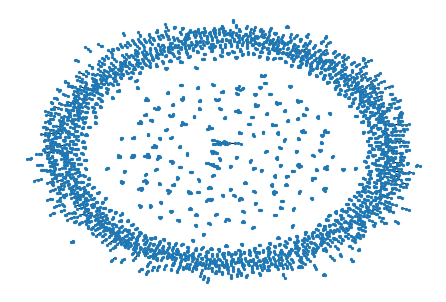

In [24]:
# We add to all of nodes the corresponding attributes, which are in the form of a dictionary.
average_rating_dict = {}
genre_dict = {}
for node in nodes: 
    genre_dict[node[0]] = node[1]
    average_rating_dict[node[0]] = node[2]

nx.set_node_attributes(G, genre_dict, 'genre')
nx.set_node_attributes(G, average_rating_dict, 'average_rating')

# Finally draw a simple network based on it.
nx.draw(G, with_labels=False, node_size=5, title='Network Profile of Movies and Casts')

In [25]:
# Density is on a scale from 0 to 1, 0 suggests no connections within these people at all, 
# and 1 indicates a perfectly connected society.
density = nx.density(G)
print("Network density:", density)
# The density at approximately 0.00034 indicates a rather discrete network. 

Network density: 0.0003414103025297088


In [88]:
# Another measurement for network density is diameter, as it suggests the shortest distance between the two farthest movies. 
# Also, the diameter of the largest component could be an approximation for the whole network's diameter.

In [26]:
# So we use nx.connected_components to get the list of components,
# then use the max() command to find the largest one:
components = nx.connected_components(G)
largest_component = max(components, key=len)

# Create a "subgraph" of the largest component
# Then calculate the diameter of the subgraph

subgraph = G.subgraph(largest_component)
diameter = nx.diameter(subgraph)
print("Network diameter of largest component:", diameter)

Network diameter of largest component: 8


In [27]:
# We also want to identify the top 20 movies with maintain high centrality in the network-wide metrics. 
# So we create dictionaries with the nodes as keys and centrality measure as values.
degree_dict = dict(G.degree(G.nodes()))
nx.set_node_attributes(G, degree_dict, 'degree')
sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)

print("Top 20 nodes by degree:")
for d in sorted_degree[:20]:
    print(d)

Top 20 nodes by degree:
(" 'Maria Petrano'", 10)
("'Thomas Carr'", 5)
("'Maria Petrano'", 5)
('A Second Chance\xa0', 4)
('Entangled\xa0', 4)
('Never Alone\xa0', 4)
('The Beast\xa0', 4)
('Kalki\xa0', 4)
("'Eric Roberts'", 3)
(" 'Alex'", 3)
(" 'Kj Schrock'", 3)
("'Thomas Freeley'", 3)
(" 'Tom Sizemore'", 3)
(" 'Claire'", 3)
("'Danny Trejo'", 3)
("'G.V. Prakash Kumar'", 3)
(" 'Maggie'", 3)
(" 'James'", 3)
("Assassins' Contract\xa0", 2)
('One Little Finger\xa0', 2)


In [28]:
# To enhance recognition towards the most influential movie, we try to identify movies which can connect two distant components of the network.
betweenness_dict = nx.betweenness_centrality(G) # Run betweenness centrality
eigenvector_dict = nx.eigenvector_centrality(G) # Run eigenvector centrality

# Assign each to an attribute in your network
nx.set_node_attributes(G, betweenness_dict, 'betweenness')
nx.set_node_attributes(G, eigenvector_dict, 'eigenvector')

# Sort betweenness centrality by changing the variable names in the sorting code above
sorted_betweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)

print("Top 20 nodes by betweenness centrality:")
for b in sorted_betweenness[:20]:
    print(b)

Top 20 nodes by betweenness centrality:
(" 'Maria Petrano'", 2.4588341232574988e-05)
('Pixy Dragons\xa0', 7.205837790523261e-06)
("'Thomas Carr'", 5.435982894605267e-06)
("'Thomas Freeley'", 5.119937377477054e-06)
("'Todd Quills'", 5.056728274051412e-06)
("'Maria Petrano'", 4.235009929518057e-06)
('Crazy Birds\xa0', 3.413291584984703e-06)
('Ogre\xa0', 3.413291584984703e-06)
('Groundhog Dave\xa0', 2.654782343876991e-06)
('The Lion Kid\xa0', 2.654782343876991e-06)
("Father's Day\xa0", 2.654782343876991e-06)
('Dog Town\xa0', 2.654782343876991e-06)
('Penguin Land\xa0', 2.654782343876991e-06)
('It Takes Three\xa0', 2.654782343876991e-06)
(" 'Tom Sizemore'", 2.528364137025706e-06)
(" 'Kj Schrock'", 2.0859004130462073e-06)
('Hell Girl\xa0', 1.8962731027692793e-06)
('The Halloween Family\xa0', 1.5170184822154233e-06)
('Dia of the Dead\xa0', 1.5170184822154233e-06)
('Kalki\xa0', 1.5170184822154233e-06)


In [29]:
# Overall,the top 20 nodes maintain the following centrality and degree.
top_betweenness = sorted_betweenness[:5]
for tb in top_betweenness: # Loop through top_betweenness
    degree = degree_dict[tb[0]] # Use degree_dict to access a node's degree
    print("Name:", tb[0], "| Betweenness Centrality:", tb[1], "| Degree:", degree)

Name:  'Maria Petrano' | Betweenness Centrality: 2.4588341232574988e-05 | Degree: 10
Name: Pixy Dragons  | Betweenness Centrality: 7.205837790523261e-06 | Degree: 2
Name: 'Thomas Carr' | Betweenness Centrality: 5.435982894605267e-06 | Degree: 5
Name: 'Thomas Freeley' | Betweenness Centrality: 5.119937377477054e-06 | Degree: 3
Name: 'Todd Quills' | Betweenness Centrality: 5.056728274051412e-06 | Degree: 2


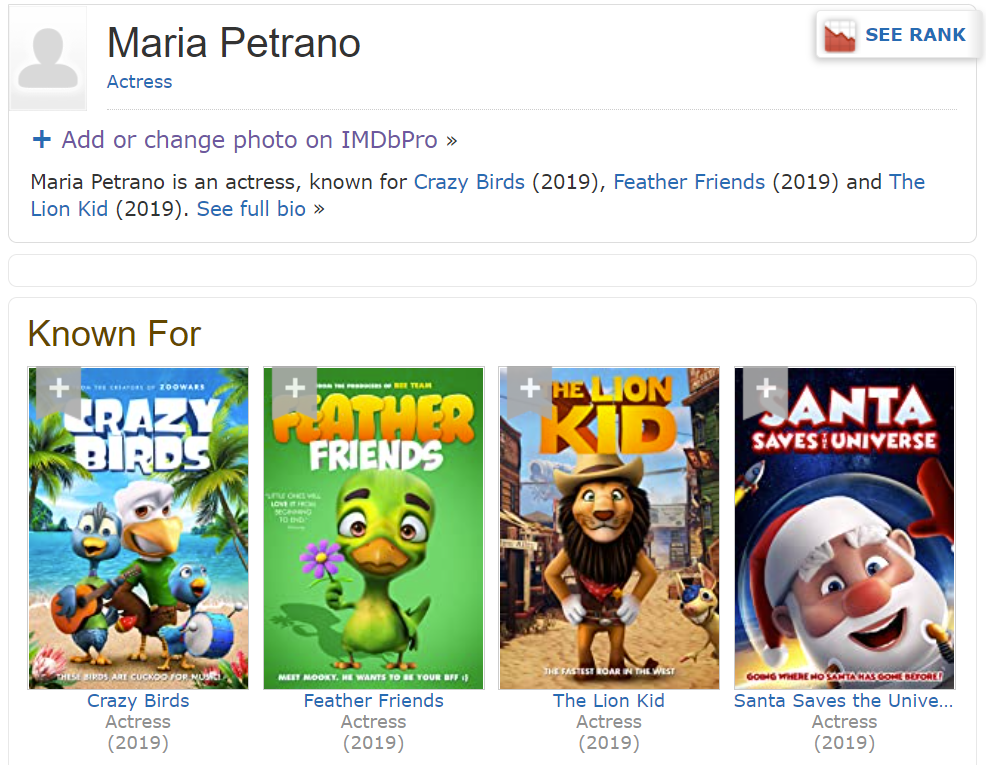

In [40]:
#We can conclude from the results that the nodes maintaining high degree are also more likely to have high betweenness centrality simultaneously. 
#Such examples include Maria Petrano, Thomas Carr, etc. Surprisingly, the top 1 popular node is a dubber...
Image(filename = "Maria Petrano.jpg", width=800, height=400)

In [13]:
import io
from nbformat import current
def nb_word_count(nb_path):
    with io.open(nb_path, 'r', encoding='utf-8') as f:
        nb = current.read(f, 'json')
        word_count = 0
        for cell in nb.worksheets[0].cells:
            if cell.cell_type == "markdown":
                word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
    return word_count

nb_path="CombinedNotebook.ipynb"

nb_word_count(nb_path)

2000